In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
from google.colab import files
import zipfile
import os
import pandas as pd
import numpy as np
import math
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D, GRU, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend

!unzip -q "/content/drive/MyDrive/104_Kinect_treadmill_records (1)" -d "/content/extracted_data"
extract_dir = "/content/extracted_data/104_Kinect_treadmill_records"

In [ ]:
def load_participant_data(extract_dir, info_filename="1_Participants information.xlsx"):
    info_file_path = os.path.join(extract_dir, info_filename)

    personalData = pd.read_excel(info_file_path)
    print("Participant data loaded successfully.")
    return personalData

personalData = load_participant_data(extract_dir)
print(personalData)

Participant data loaded successfully.
             Marca temporal  File name  Age        SEX  1=M/2=F SEX  \
0   2019-06-10 11:46:48.225          1   26   FEMENINO            2   
1   2019-06-10 11:52:04.799          2   22   FEMENINO            2   
2   2019-06-10 12:06:03.149          3   24  MASCULINO            1   
3   2019-06-10 12:15:44.080          4   21   FEMENINO            2   
4   2019-06-10 12:30:26.021          5   22   FEMENINO            2   
..                      ...        ...  ...        ...          ...   
99  2019-06-17 16:25:42.785        100   20  MASCULINO            1   
100 2019-06-17 17:08:04.762        101   20  MASCULINO            1   
101 2019-06-17 17:11:51.086        102   19  MASCULINO            1   
102 2019-06-17 17:23:26.284        103   19   FEMENINO            2   
103 2019-06-17 17:26:58.984        104   20   FEMENINO            2   

     Height(cm)  Weight(kg)  
0         158.0        53.6  
1         172.0        59.0  
2         175.0    

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.interpolate import PchipInterpolator
from scipy.signal import butter, filtfilt
import warnings
import traceback

TARGET_CYCLE_LENGTH = 50

SAMPLING_FREQUENCY = 30
CUTOFF_FREQUENCY = 4
FILTER_ORDER = 8

MIN_CYCLES_FOR_LENGTH_FILTER = 2
CYCLE_LENGTH_STD_MULTIPLIER = 1.5

columns_to_extract_initial = [
    "Time", "Left_hip_x", "Left_hip_y", "Left_hip_z",
    "Left_knee_x", "Left_knee_y", "Left_knee_z",
    "Left_ankle_x", "Left_ankle_y", "Left_ankle_z",
    "Left_foot_x", "Left_foot_y", "Left_foot_z",
    "Lower_spine_x", "Lower_spine_y", "Lower_spine_z",
    "Right_hip_x", "Right_hip_y", "Right_hip_z",
    "Right_knee_x", "Right_knee_y", "Right_knee_z",
    "Right_ankle_x", "Right_ankle_y", "Right_ankle_z",
    "Right_foot_x", "Right_foot_y", "Right_foot_z",
    "Distance_between_ankles_z", "Steps"
]

columns_to_interpolate = [
    "Time", "Left_hip_x", "Left_hip_y", "Left_hip_z",
    "Left_knee_x", "Left_knee_y", "Left_knee_z",
    "Left_ankle_x", "Left_ankle_y", "Left_ankle_z",
    "Left_foot_x", "Left_foot_y", "Left_foot_z",
    "Lower_spine_x", "Lower_spine_y", "Lower_spine_z",
    "Right_hip_x", "Right_hip_y", "Right_hip_z",
    "Right_knee_x", "Right_knee_y", "Right_knee_z",
    "Right_ankle_x", "Right_ankle_y", "Right_ankle_z",
    "Right_foot_x", "Right_foot_y", "Right_foot_z",
    "Distance_between_ankles_z"
]

columns_to_filter = [col for col in columns_to_interpolate if col != 'Time'] # Filter everything except Time

columns_to_keep_constant = [
    'gait_cycle', 'age', 'File name',
    'walking_speed_mps', 'cycle_duration_sec', 'stride_length_meters'
]

final_columns_order = columns_to_interpolate + [
    'left_knee_angle', 'right_knee_angle', 'left_ankle_angle',
    'right_ankle_angle', 'left_hip_angle', 'right_hip_angle'] \
+ columns_to_keep_constant \
+ ['normalized_cycle_time', 'original_cycle_length']

def angle_between_vectors(v1, v2):
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)

    if np.any(np.isnan(v1)) or np.any(np.isnan(v2)):
        return np.nan

    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        # print("Warning: Zero vector encountered in angle calculation.") # Optional debug
        return np.nan

    v1_u = v1 / norm_v1
    v2_u = v2 / norm_v2

    dot_product = np.dot(v1_u, v2_u)
    clipped_dot_product = np.clip(dot_product, -1.0, 1.0)

    angle = np.arccos(clipped_dot_product)
    return angle

def apply_butterworth_filter(data, order, cutoff, fs, columns_to_filter):
    print(f"    Applying Butterworth filter (fs={fs}Hz, cutoff={cutoff}Hz, order={order})...")

    nyquist = 0.5 * fs
    if nyquist <= 0:
        print("    Error: Sampling frequency is zero or negative. Cannot apply filter.")
        return data

    normal_cutoff = cutoff / nyquist
    if normal_cutoff >= 1:
        print(f"    Warning: Normalized cutoff frequency ({normal_cutoff:.2f}) is >= 1.0 (Nyquist). Skipping filtering.")
        return data

    if normal_cutoff <= 0:
        print(f"    Warning: Normalized cutoff frequency ({normal_cutoff:.2f}) is <= 0. Skipping filtering.")
        return data

    b, a = butter(order, normal_cutoff, btype='lowpass')
    filtered_data = data.copy()

    cols_present_to_filter = [col for col in columns_to_filter if col in filtered_data.columns]
    if not cols_present_to_filter:
        print("    No filterable columns found in DataFrame. Skipping filtering.")
        return data

    initial_nan_counts = filtered_data[cols_present_to_filter].isnull().sum()
    nan_cols_before_filter = initial_nan_counts[initial_nan_counts > 0].index.tolist()

    if nan_cols_before_filter:
        print(f"    Warning: NaN values found in columns before filtering: {nan_cols_before_filter}. Filtering will be skipped for these columns.")
        cols_to_actually_filter = filtered_data[cols_present_to_filter].columns[filtered_data[cols_present_to_filter].notna().all()].tolist()
        skipped_filter_cols = [col for col in cols_present_to_filter if col not in cols_to_actually_filter]
        if skipped_filter_cols:
             print(f"    Skipping filtering for columns with remaining NaNs: {skipped_filter_cols}")
    else:
        cols_to_actually_filter = cols_present_to_filter

    min_len_for_filtfilt = 3 * order
    if len(filtered_data) < min_len_for_filtfilt:
        print(f"    Warning: DataFrame length ({len(filtered_data)}) is less than required for robust filtfilt ({min_len_for_filtfilt}). Skipping filtering for this data segment.")
        return data

    for col in cols_to_actually_filter:
        filtered_data[col] = filtfilt(b, a, filtered_data[col].values)
    return filtered_data


all_participants_data = []
processed_files_count = 0
skipped_files_count = 0
total_cycles_processed = 0
total_cycles_skipped_length_filter = 0
total_cycles_skipped_initial_checks = 0
total_cycles_skipped_interp_errors = 0

personalData['File name'] = personalData['File name'].astype(str)

file_processing_can_start = False
if 'extract_dir' in globals() and isinstance(extract_dir, str) and os.path.isdir(extract_dir):
    file_processing_can_start = True
    files_to_process = [f for f in os.listdir(extract_dir) if f.startswith("K3") and f.endswith(".xlsx")]
    print(f"Found {len(files_to_process)} potential files starting with 'K3' in '{extract_dir}'.")
else:
    print("Error: 'extract_dir' is not defined, not a valid path string, or the directory does not exist. Skipping file processing.")

if file_processing_can_start:
    for file_name in files_to_process:
        file_path = os.path.join(extract_dir, file_name)
        print(f"\n--- Processing file: {file_name} ---")
        participant_id_str = file_name[2:5]
        df = pd.read_excel(file_path)

        # Convert relevant columns to numeric, coercing errors to NaN
        cols_to_numeric_conversion = list(set(columns_to_extract_initial))
        for col in cols_to_numeric_conversion:
             if col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce')

        # Select only the initially required columns
        # Note: 'sex', 'height(cm)', 'weight(kg)' are NOT added here
        df_working = df[columns_to_extract_initial].copy()

        # Match participant personal data
        participant_id = int(participant_id_str)
        # Use regex to match participant ID at the start of the 'File name' string
        participant_info = personalData[personalData['File name'].astype(str).str.contains(f"^{participant_id:d}", na=False)]

        # Add personal data ('age' and 'File name' to df_working)
        age_val = np.nan
        if not participant_info.empty:
            if len(participant_info) > 1:
                 print(f"Warning: Multiple personal data entries found for participant ID {participant_id} from file {file_name}. Using the first match.")
                 participant_info = participant_info.iloc[[0]]

            participant_row = participant_info.iloc[0]

            # Get age value, default to NaN if column missing or value is NaN
            age_val = participant_row.get('Age', np.nan)
            if pd.isna(age_val):
                 print(f"Warning: Age is NaN for participant {participant_id} from file {file_name}.")

            # Add 'age' and 'File name' to the working DataFrame
            df_working['age'] = age_val
            df_working['File name'] = file_name
        else:
            print(f"Warning: No personal data found for participant ID {participant_id} from file {file_name}. Age will be NaN.")
            df_working['age'] = np.nan # Ensure age column exists with NaN
            df_working['File name'] = file_name # Ensure File name column exists


        # Apply Butterworth filter
        if SAMPLING_FREQUENCY > 0 and CUTOFF_FREQUENCY > 0 and FILTER_ORDER > 0:
             # Pass only the relevant columns to the filter function
             df_filtered = apply_butterworth_filter(df_working.copy(), FILTER_ORDER, CUTOFF_FREQUENCY, SAMPLING_FREQUENCY, columns_to_filter)
        else:
             print(f"Warning: Invalid filtering parameters (fs={SAMPLING_FREQUENCY}, cutoff={CUTOFF_FREQUENCY}, order={FILTER_ORDER}). Skipping Butterworth filtering for {file_name}.")
             df_filtered = df_working.copy()

        # Check for the critical 'Steps' column after filtering
        if 'Steps' not in df_filtered.columns:
             print(f"Error: 'Steps' column not found in file {file_name} after filtering step. Cannot identify gait cycles. Skipping file.")
             skipped_files_count += 1
             continue # Skip to the next file

        # Ensure 'Steps' column is numeric and handle NaNs
        steps_series = pd.to_numeric(df_filtered['Steps'].copy(), errors='coerce')

        if steps_series.isnull().any():
            original_nan_count = steps_series.isnull().sum()
            print(f"Warning: {original_nan_count} NaN values found in 'Steps' column for {file_name}. Attempting fill...")
            # Forward fill, then backward fill, then fill any remaining with 0
            steps_series = steps_series.ffill().bfill().fillna(0)
            if steps_series.isnull().any():
                 remaining_nan_count = steps_series.isnull().sum()
                 print(f"Error: {remaining_nan_count} NaNs still present in 'Steps' after ffill/bfill/fillna(0) in {file_name}. Skipping file due to critical Steps data issues.")
                 skipped_files_count += 1
                 continue # Skip the file

        # Convert steps to integer array
        steps = steps_series.astype(int).values

        # Identify gait cycles based on 'Steps' increments
        df_filtered['gait_cycle'] = 0 # Initialize gait cycle column
        gait_cycle_counter = 0
        gait_cycles = np.zeros(len(df_filtered), dtype=int)
        step_count_in_cycle = 0 # Counts steps within the current potential cycle
        last_step_val = steps[0] if len(steps) > 0 and not np.isnan(steps[0]) else 0 # Handle potential initial NaN

        # Iterate through steps to identify cycle boundaries (two steps = one cycle)
        for i in range(len(steps)):
            current_step_val = steps[i]

            # Check for a valid step increment (current > last and current > 0)
            if not np.isnan(current_step_val) and not np.isnan(last_step_val) and current_step_val > last_step_val and current_step_val > 0:
                step_count_in_cycle += 1
                if step_count_in_cycle == 2: # A full cycle is identified after the second step
                    gait_cycle_counter += 1 # Increment cycle counter
                    step_count_in_cycle = 0 # Reset step counter for the next cycle

            # Assign the current gait cycle number to the row
            gait_cycles[i] = gait_cycle_counter

            # Update last_step_val if the current value is not NaN
            if not np.isnan(current_step_val):
                last_step_val = current_step_val

        # Assign the identified gait cycles back to the DataFrame
        df_filtered['gait_cycle'] = gait_cycles

        # Filter out rows that do not belong to a complete cycle (cycle_num > 0)
        df_cycles_only = df_filtered[df_filtered['gait_cycle'] > 0].copy().reset_index(drop=True)

        # Check if any complete cycles were found
        if df_cycles_only.empty:
            print(f"Warning: No complete gait cycles (cycle_num > 0) found in {file_name}. Skipping file.")
            skipped_files_count += 1 # Count the file as skipped since no processable cycles found
            continue # Skip to the next file

        # Analyze cycle lengths and apply length filtering
        print("    Analysing cycle lengths before interpolation...")
        cycle_lengths = df_cycles_only.groupby('gait_cycle').size()
        unique_cycle_numbers = cycle_lengths.index.tolist() # Get cycle numbers as a list

        cycles_to_process_for_participant = []
        cycles_skipped_length_filter_for_participant = 0

        # Apply length filtering only if there are enough cycles
        if len(unique_cycle_numbers) >= MIN_CYCLES_FOR_LENGTH_FILTER:
             mean_len = cycle_lengths.mean()
             std_len = cycle_lengths.std()
             lower_bound = mean_len - CYCLE_LENGTH_STD_MULTIPLIER * std_len
             upper_bound = mean_len + CYCLE_LENGTH_STD_MULTIPLIER * std_len
             print(f"    Cycle length filter: Mean={mean_len:.2f}, Std={std_len:.2f}, Bounds=[{lower_bound:.2f}, {upper_bound:.2f}] (using multiplier {CYCLE_LENGTH_STD_MULTIPLIER})")

             for cycle_num in unique_cycle_numbers:
                 current_len = cycle_lengths.loc[cycle_num]
                 if lower_bound <= current_len <= upper_bound:
                     cycles_to_process_for_participant.append(cycle_num)
                 else:
                     print(f"    - Skipping cycle {cycle_num}: Length {current_len} outside [{lower_bound:.2f}, {upper_bound:.2f}].")
                     total_cycles_skipped_length_filter += 1
                     cycles_skipped_length_filter_for_participant += 1

             if cycles_skipped_length_filter_for_participant > 0:
                  print(f"    Skipped {cycles_skipped_length_filter_for_participant} cycles due to length deviation in {file_name}.")

             if not cycles_to_process_for_participant:
                  print(f"    Warning: No cycles remain after length filtering for file {file_name}. Skipping file.")
                  skipped_files_count += 1 # Count the file as skipped
                  continue # Skip to the next file

        else:
             print(f"    Skipping cycle length filtering: Only {len(unique_cycle_numbers)} cycles found (< {MIN_CYCLES_FOR_LENGTH_FILTER}) in {file_name}.")
             cycles_to_process_for_participant = unique_cycle_numbers # Process all found cycles

        print(f"    Proceeding with {len(cycles_to_process_for_participant)} cycles for interpolation and angle calculation.")

        # --- Cycle Processing Loop for Interpolation and Angles ---
        interpolated_cycles_for_participant = []
        for cycle_num in cycles_to_process_for_participant:
             # Select data for the current cycle
             cycle_df = df_cycles_only[df_cycles_only['gait_cycle'] == cycle_num].copy().reset_index(drop=True)
             original_length = len(cycle_df) # Store original length

             MIN_POINTS_FOR_PCHIP = 2
             if original_length < MIN_POINTS_FOR_PCHIP:
                  print(f"    - Skipping cycle {cycle_num}: Insufficient points ({original_length} < {MIN_POINTS_FOR_PCHIP}) for PCHIP interpolation.")
                  total_cycles_skipped_initial_checks += 1
                  continue # Skip to the next cycle

             required_cols_for_metrics = ['Time', 'Distance_between_ankles_z'] # 'Steps' is not needed here
             if not all(col in cycle_df.columns for col in required_cols_for_metrics) or cycle_df[required_cols_for_metrics].isnull().any().any():
                  missing_or_nan_metric_cols = [col for col in required_cols_for_metrics if col not in cycle_df.columns or cycle_df[col].isnull().any()]
                  print(f"    - Skipping cycle {cycle_num}: Missing or NaN values found in columns required for metric calculation ({missing_or_nan_metric_cols}) in cycle slice.")
                  total_cycles_skipped_initial_checks += 1
                  continue # Skip to the next cycle

             original_time_points = cycle_df['Time'].values
             original_ankle_dist_z = cycle_df['Distance_between_ankles_z'].values

             cycle_duration_sec = original_time_points[-1] - original_time_points[0]

             walking_speed_mps = np.nan # Initialize metrics to NaN
             stride_length_meters = np.nan

             # Calculate stride length and walking speed if possible
             if original_length > 0: # This check is mostly redundant due to MIN_POINTS_FOR_PCHIP check
                  ankle_dist_at_start = original_ankle_dist_z[0]
                  ankle_dist_at_end = original_ankle_dist_z[-1]

                  if not np.isnan(ankle_dist_at_start) and not np.isnan(ankle_dist_at_end):
                       # Stride length is the sum of the absolute Z distances at the start and end of the cycle
                       stride_length_meters = abs(ankle_dist_at_start) + abs(ankle_dist_at_end)

                       # Calculate walking speed if cycle duration is valid
                       if cycle_duration_sec is not None and cycle_duration_sec > 1e-6:
                            walking_speed_mps = stride_length_meters / cycle_duration_sec
                       else:
                            print(f"    - Warning: Cycle duration is zero or very small ({cycle_duration_sec:.4f} sec) for cycle {cycle_num}. Walking speed set to NaN.")
                            walking_speed_mps = np.nan # Explicitly set to NaN if duration is problematic
                  else:
                       print(f"    - Warning: NaN values found in 'Distance_between_ankles_z' at start or end of cycle slice {cycle_num}. Stride length and walking speed set to NaN.")
                       # Metrics remain NaN initialized
             else:
                  print(f"    - Error: Cycle {cycle_num} has zero length during metric calculation. Should have been skipped earlier.")
                  # Metrics remain NaN initialized

             original_indices = np.arange(original_length) # X values for interpolation source: 0, 1, ..., N-1
             new_indices = np.linspace(0, original_length - 1, TARGET_CYCLE_LENGTH) # Target X values for interpolation (0 to N-1, with TARGET_CYCLE_LENGTH points)

             interpolated_data = {}

             for col in columns_to_interpolate:
                  if col in cycle_df.columns:
                       original_values = cycle_df[col].values # Y values from the filtered cycle slice data
                       # Check for NaNs in the column data before interpolation
                       if np.isnan(original_values).any():
                            print(f"    - Skipping column '{col}' for interpolation in cycle {cycle_num} of {file_name}: NaN values found in original data for this column slice.")
                            # If NaNs are present, the interpolated data for this column will be an array of NaNs
                            interpolated_data[col] = np.full(TARGET_CYCLE_LENGTH, np.nan)
                       else:
                            # Perform interpolation if enough points and no NaNs
                            if len(original_indices) >= MIN_POINTS_FOR_PCHIP:
                                 try:
                                     f_interp = PchipInterpolator(original_indices, original_values)
                                     interpolated_values = f_interp(new_indices)
                                     interpolated_data[col] = interpolated_values
                                 except Exception as e:
                                     print(f"    - ERROR during PCHIP interpolation for column '{col}' in cycle {cycle_num}: {e}. Interpolated data for this column set to NaN.")
                                     traceback.print_exc()
                                     interpolated_data[col] = np.full(TARGET_CYCLE_LENGTH, np.nan)
                            else: # Should not happen due to initial length check, but as a safeguard
                                 print(f"    - Error interpolating column '{col}' for cycle {cycle_num}: Not enough data points ({len(original_indices)}) for PCHIP interpolation.")
                                 interpolated_data[col] = np.full(TARGET_CYCLE_LENGTH, np.nan)
                  else:
                       print(f"    - Critical Error: Column {col} not found in cycle_df for interpolation for cycle {cycle_num}. Filling with NaNs.")
                       # Fill with NaNs if the column is unexpectedly missing
                       interpolated_data[col] = np.full(TARGET_CYCLE_LENGTH, np.nan)

             interpolated_df = pd.DataFrame(interpolated_data)

             # Check if required coordinate columns for angle calculation are present and have no NaNs
             required_angle_coord_cols = [c for c in columns_to_interpolate if '_x' in c or '_y' in c or '_z' in c]
             coords_ok_for_angles = True
             missing_or_nan_coord_cols = []
             for col in required_angle_coord_cols:
                  # Check if column exists in the interpolated DataFrame and has no NaNs
                  if col not in interpolated_df.columns or interpolated_df[col].isnull().any():
                       coords_ok_for_angles = False
                       missing_or_nan_coord_cols.append(col)

             # Calculate joint angles if coordinate data is valid
             angle_data = {}
             if not coords_ok_for_angles:
                  print(f"    - Skipping angle calculation for cycle {cycle_num} in {file_name}: Missing or NaN values in interpolated coordinate data required for angles ({missing_or_nan_coord_cols}). Angle columns will be NaN.")
                  # Fill angle columns with NaNs if coordinates are bad
                  for angle_col in ['left_knee_angle', 'right_knee_angle', 'left_ankle_angle', 'right_ankle_angle', 'left_hip_angle', 'right_hip_angle']:
                       angle_data[angle_col] = np.full(TARGET_CYCLE_LENGTH, np.nan)
                  total_cycles_skipped_interp_errors += 1 # Count as interpolation/angle calc skip reason
                  # Continue processing this cycle, but angles will be NaN
             else:
                  # Extract interpolated coordinate arrays
                  left_hip_interp = interpolated_df[["Left_hip_x", "Left_hip_y", "Left_hip_z"]].values
                  left_knee_interp = interpolated_df[["Left_knee_x", "Left_knee_y", "Left_knee_z"]].values
                  left_ankle_interp = interpolated_df[["Left_ankle_x", "Left_ankle_y", "Left_ankle_z"]].values
                  left_foot_interp = interpolated_df[["Left_foot_x", "Left_foot_y", "Left_foot_z"]].values
                  lower_spine_interp = interpolated_df[["Lower_spine_x", "Lower_spine_y", "Lower_spine_z"]].values
                  right_hip_interp = interpolated_df[["Right_hip_x", "Right_hip_y", "Right_hip_z"]].values
                  right_knee_interp = interpolated_df[["Right_knee_x", "Right_knee_y", "Right_knee_z"]].values
                  right_ankle_interp = interpolated_df[["Right_ankle_x", "Right_ankle_y", "Right_ankle_z"]].values
                  right_foot_interp = interpolated_df[["Right_foot_x", "Right_foot_y", "Right_foot_z"]].values

                  # Calculate angles using the helper function
                  angle_data = {
                       'left_knee_angle': [angle_between_vectors(h - k, a - k) for h, k, a in zip(left_hip_interp, left_knee_interp, left_ankle_interp)],
                       'right_knee_angle': [angle_between_vectors(h - k, a - k) for h, k, a in zip(right_hip_interp, right_knee_interp, right_ankle_interp)],
                       'left_ankle_angle': [angle_between_vectors(k - a, f - a) for k, a, f in zip(left_knee_interp, left_ankle_interp, left_foot_interp)],
                       'right_ankle_angle': [angle_between_vectors(k - a, f - a) for k, a, f in zip(right_knee_interp, right_ankle_interp, right_foot_interp)],
                       'left_hip_angle': [angle_between_vectors(ls - h, k - h) for ls, h, k in zip(lower_spine_interp, left_hip_interp, left_knee_interp)],
                       'right_hip_angle': [angle_between_vectors(ls - h, k - h) for ls, h, k in zip(lower_spine_interp, right_hip_interp, right_knee_interp)]
                  }

                  angle_cols_calculated = list(angle_data.keys())
                  if any(np.isnan(angle_data[col]).any() for col in angle_cols_calculated):
                       nan_angle_cols = [col for col in angle_cols_calculated if np.isnan(angle_data[col]).any()]
                       print(f"    - Skipping cycle {cycle_num} in {file_name}: NaNs found in calculated angle data ({nan_angle_cols}). Angle columns will be NaN.")
                       # Ensure all angle columns are NaN if any calculation failed for this cycle
                       for angle_col in angle_cols_calculated:
                            angle_data[angle_col] = np.full(TARGET_CYCLE_LENGTH, np.nan)
                       total_cycles_skipped_interp_errors += 1 # Count as interpolation/angle calc skip reason

             processed_cycle_data = {**interpolated_data, **angle_data}

             try:
                  cycle_gait_cycle = cycle_df['gait_cycle'].iloc[0]
                  cycle_age = cycle_df.get('age', np.nan).iloc[0] if 'age' in cycle_df.columns else np.nan
                  cycle_file_name = cycle_df.get('File name', file_name).iloc[0] if 'File name' in cycle_df.columns else file_name

                  cycle_walking_speed_mps = walking_speed_mps
                  cycle_cycle_duration_sec = cycle_duration_sec
                  cycle_stride_length_meters = stride_length_meters

                  if pd.isna(cycle_gait_cycle) or pd.isna(cycle_file_name) or cycle_file_name == '':
                       print(f"    - Skipping cycle {cycle_num} in {file_name}: NaN or missing value found in critical constant columns (gait_cycle or File name) extracted from original data.")
                       total_cycles_skipped_interp_errors += 1 # Count as interpolation/angle calc skip reason
                       continue # Skip cycle if basic constants are missing/NaN derived from original data

             except Exception as e:
                  print(f"    - ERROR extracting base constant values for cycle {cycle_num} in {file_name}: {e}. Skipping this cycle.")
                  traceback.print_exc()
                  total_cycles_skipped_interp_errors += 1 # Count as interpolation/angle calc skip reason
                  continue # Skip cycle on error

             processed_cycle_data['gait_cycle'] = [cycle_gait_cycle] * TARGET_CYCLE_LENGTH
             processed_cycle_data['age'] = [cycle_age] * TARGET_CYCLE_LENGTH
             processed_cycle_data['File name'] = [cycle_file_name] * TARGET_CYCLE_LENGTH
             processed_cycle_data['walking_speed_mps'] = [cycle_walking_speed_mps] * TARGET_CYCLE_LENGTH
             processed_cycle_data['cycle_duration_sec'] = [cycle_cycle_duration_sec] * TARGET_CYCLE_LENGTH
             processed_cycle_data['stride_length_meters'] = [cycle_stride_length_meters] * TARGET_CYCLE_LENGTH

             # --- Add normalized time/progress within the cycle and original length ---
             processed_cycle_data['normalized_cycle_time'] = np.linspace(0, 1, TARGET_CYCLE_LENGTH)
             processed_cycle_data['original_cycle_length'] = [original_length] * TARGET_CYCLE_LENGTH # Store original length

             # --- Create Final DataFrame for this cycle ---
             missing_final_cols = [col for col in final_columns_order if col not in processed_cycle_data]
             if missing_final_cols:
                  print(f"    - Skipping cycle {cycle_num} in {file_name}: Missing columns required for final DataFrame: {missing_final_cols}. Check processing logic.")
                  total_cycles_skipped_interp_errors += 1 # Count as interpolation/angle calc skip reason
                  continue # Skip this cycle

             interpolated_cycle_df = pd.DataFrame(processed_cycle_data)[final_columns_order]

             interpolated_cycles_for_participant.append(interpolated_cycle_df)
             total_cycles_processed += 1 # Increment counter for successfully processed cycles

        if interpolated_cycles_for_participant:
             try:
                  participant_interpolated_df = pd.concat(interpolated_cycles_for_participant, ignore_index=True)
                  # Append the participant's data to the overall list
                  all_participants_data.append(participant_interpolated_df)
                  print(f"    + Successfully processed {len(interpolated_cycles_for_participant)} cycles for {file_name}.")
                  processed_files_count += 1 # Increment file processed count
             except Exception as concat_e:
                  print(f"Error concatenating processed cycles for file {file_name}: {concat_e}. Data for this file might be missing.")
                  traceback.print_exc()
                  # The file is counted as processed, but its cycles might not be in all_participants_data
        else:
             print(f"    - Warning: No gait cycles were successfully processed for {file_name} (check skip messages above).")
             pass # No need to increment skipped_files_count here, as individual cycle skips are counted


else:
    print("\nSkipping file processing as setup was not complete or directory invalid.")


if all_participants_data:
    # Concatenate all participant DataFrames into a single DataFrame
    try:
        common_df = pd.concat(all_participants_data, ignore_index=True)
        print("\n--- Processing Summary ---")
        print(f"Total files found: {len(files_to_process) if 'files_to_process' in globals() else 0}")
        print(f"Total files successfully processed: {processed_files_count}")
        print(f"Total files skipped due to errors: {skipped_files_count}")
        print(f"Total gait cycles processed: {total_cycles_processed}")
        print(f"Total gait cycles skipped (initial checks/interpolation/angle errors): {total_cycles_skipped_initial_checks + total_cycles_skipped_interp_errors}")
        print(f"Total gait cycles skipped (length filter): {total_cycles_skipped_length_filter}")
        print(f"Final DataFrame shape: {common_df.shape}")
    except Exception as final_concat_e:
        print(f"\nError during final concatenation of all participant data: {final_concat_e}. Final DataFrame might be empty or incomplete.")
        traceback.print_exc()
        common_df = pd.DataFrame() # Ensure common_df is defined even if concatenation fails
else:
    common_df = pd.DataFrame()
    print("\nWarning: No participant data was loaded or processed successfully to create a final DataFrame.")
    print("\n--- Processing Summary ---")
    print(f"Total files found: {len(files_to_process) if 'files_to_process' in globals() else 0}")
    print(f"Total files successfully processed: {processed_files_count}")
    print(f"Total files skipped due to errors: {skipped_files_count}")
    print(f"Total gait cycles processed: {total_cycles_processed}")
    print(f"Total gait cycles skipped (initial checks/interpolation/angle errors): {total_cycles_skipped_initial_checks + total_cycles_skipped_interp_errors}")
    print(f"Total gait cycles skipped (length filter): {total_cycles_skipped_length_filter}")
    print("Final DataFrame is empty.")

Found 104 potential files starting with 'K3' in '/kaggle/input/aaasss/104_Kinect_treadmill_records'.

--- Processing file: K3058.xlsx ---
    Applying Butterworth filter (fs=30Hz, cutoff=4Hz, order=8)...
    Analysing cycle lengths before interpolation...
    Cycle length filter: Mean=36.58, Std=3.52, Bounds=[31.29, 41.86] (using multiplier 1.5)
    - Skipping cycle 26: Length 20 outside [31.29, 41.86].
    Skipped 1 cycles due to length deviation in K3058.xlsx.
    Proceeding with 25 cycles for interpolation and angle calculation.
    + Successfully processed 25 cycles for K3058.xlsx.

--- Processing file: K3084.xlsx ---
    Applying Butterworth filter (fs=30Hz, cutoff=4Hz, order=8)...
    Analysing cycle lengths before interpolation...
    Cycle length filter: Mean=40.50, Std=4.86, Bounds=[33.20, 47.80] (using multiplier 1.5)
    - Skipping cycle 24: Length 18 outside [33.20, 47.80].
    Skipped 1 cycles due to length deviation in K3084.xlsx.
    Proceeding with 23 cycles for interpo

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, concatenate, TimeDistributed, Reshape, RepeatVector
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error
import numpy as np

if not common_df.empty:
    # Define the dynamic features (sequential data) - exclude height and sex
    dynamic_features = [
        'left_knee_angle', 'right_knee_angle', 'left_ankle_angle',
        'right_ankle_angle', 'left_hip_angle', 'right_hip_angle',
        'walking_speed_mps', 'stride_length_meters'
    ]

    # Define the output features (what the model predicts)
    output_features = [
       'left_knee_angle', 'right_knee_angle', 'left_ankle_angle',
       'right_ankle_angle', 'left_hip_angle', 'right_hip_angle'
    ]
    num_output_features = len(output_features)
    sequence_length = 50 # Length of each time sequence

    def prepare_lstm_data(df, dynamic_cols, sequence_length):
        X_dynamic = []
        y = []
        participant_ids = df['File name'].unique()

        for participant_id in participant_ids:
            participant_data = df[df['File name'] == participant_id].sort_values('Time')
            dynamic_data = participant_data[dynamic_cols].values
            output_data = participant_data[output_features].values

            for i in range(len(dynamic_data) - sequence_length):
                X_dynamic.append(dynamic_data[i: i + sequence_length])
                y.append(output_data[i + 1: i + sequence_length + 1])
        return np.array(X_dynamic), np.array(y)

    X_dynamic, y = prepare_lstm_data(common_df.copy(), dynamic_features, sequence_length)
    print(f"Shape of X_dynamic after prepare_lstm_data: {X_dynamic.shape}")
    print(f"Shape of y after prepare_lstm_data: {y.shape}")

    dynamic_preprocessor = StandardScaler()
    X_dynamic_processed = dynamic_preprocessor.fit_transform(X_dynamic.reshape(-1, X_dynamic.shape[-1])).reshape(X_dynamic.shape)


    X_train, X_temp, y_train, y_temp = train_test_split(
        X_dynamic_processed, y, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

    dynamic_input = Input(shape=(sequence_length, len(dynamic_features)), name='dynamic_input')
    lstm1 = LSTM(128, return_sequences=True)(dynamic_input)
    bilstm = Bidirectional(LSTM(256, return_sequences=True))(lstm1)
    lstm2 = LSTM(128, return_sequences=True)(bilstm)
    output = TimeDistributed(Dense(num_output_features))(lstm2)

    model = Model(inputs=dynamic_input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=50,
        validation_data=(X_val, y_val),
    )

    predictions = model.predict(X_test)

    rmse_per_angle = []
    for i in range(num_output_features):
        mse = mean_squared_error(y_test[:, :, i], predictions[:, :, i])
        rmse = np.sqrt(mse)
        rmse_degrees = np.degrees(rmse)  # Convert radians to degrees
        rmse_per_angle.append(rmse_degrees)

    print("RMSE for each angle (degrees):")
    for i, angle_name in enumerate(output_features):
        print(f"{angle_name}: {rmse_per_angle[i]:.4f}")


Shape of X_dynamic after prepare_lstm_data: (118500, 50, 8)
Shape of y after prepare_lstm_data: (118500, 50, 6)
X_train shape: (82950, 50, 8)
y_train shape: (82950, 50, 6)


I0000 00:00:1746118638.476217      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746118638.476985      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1746118648.649099     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


1659/1659 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.0987 - val_loss: 2.2451e-04
Epoch 2/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 2.4618e-04 - val_loss: 1.4473e-04
Epoch 3/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 1.3270e-04 - val_loss: 7.8054e-05
Epoch 4/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 9.3152e-05 - val_loss: 4.2116e-05
Epoch 5/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 6.4341e-05 - val_loss: 7.3693e-05
Epoch 6/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 4.9111e-05 - val_loss: 6.7622e-05
Epoch 7/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 3.5687e-05 - val_loss: 1.6156e-05
Epoch 8/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 2.9020e-05 - val_loss: 1.6239e-05
Epoch 9/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 2.1572e-05 - val_loss: 2.1885e-05
Epoch 10/10
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 1.9066e-05 - val_loss: 4.3982e-05
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 7m



--- Verifying Required Variables ---
All required variables (common_df, model, dynamic_preprocessor) confirmed and appear valid.

--- Preparing Prediction for Plotting (Cycle-Based) ---
Processing data for individual file: 'K3005.xlsx'
Found 22 potential gait cycles for 'K3005.xlsx'.
  Processing cycle 1 (length=50)...
  Processing cycle 2 (length=50)...
  Processing cycle 3 (length=50)...
  Processing cycle 4 (length=50)...
  Processing cycle 5 (length=50)...
  Processing cycle 6 (length=50)...
  Processing cycle 7 (length=50)...
  Processing cycle 8 (length=50)...
  Processing cycle 9 (length=50)...
  Processing cycle 10 (length=50)...
  Processing cycle 11 (length=50)...
  Processing cycle 12 (length=50)...
  Processing cycle 13 (length=50)...
  Processing cycle 14 (length=50)...
  Processing cycle 15 (length=50)...
  Processing cycle 16 (length=50)...
  Processing cycle 17 (length=50)...
  Processing cycle 18 (length=50)...
  Processing cycle 19 (length=50)...
  Processing cycle 

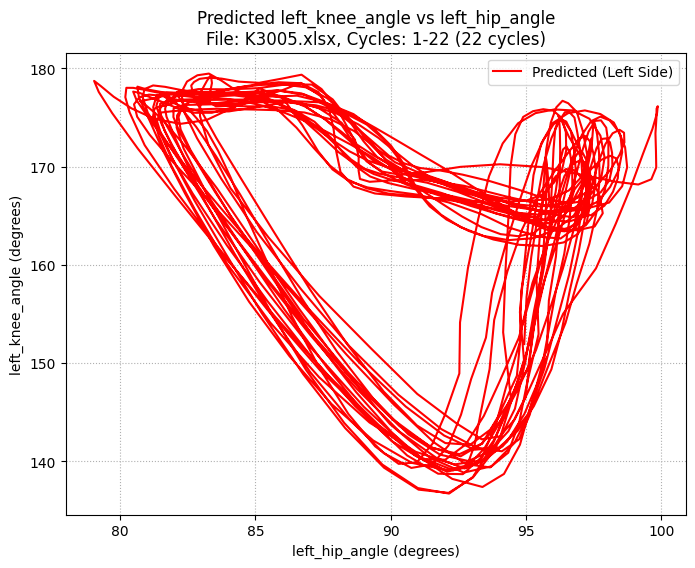


--- Plotting Predicted d(angle)/dt vs. angle (Phase Plots) for Selected Cycles ---


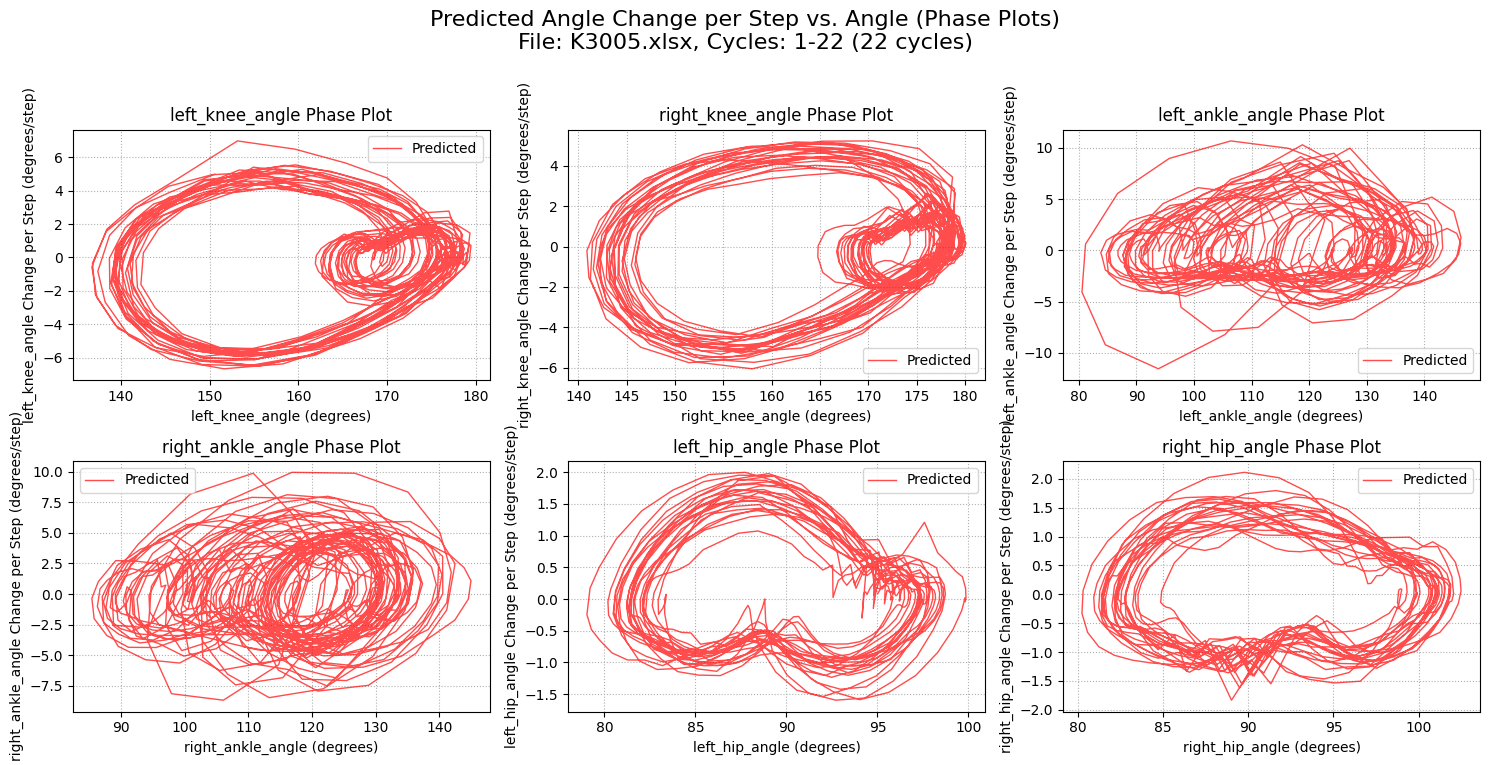


--- Script Finished ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import traceback
from sklearn.preprocessing import StandardScaler

TARGET_FILE_NAME = 'K3005.xlsx'

MAX_CYCLES_TO_PLOT = 30
dynamic_features = [
    'left_knee_angle', 'right_knee_angle', 'left_ankle_angle',
    'right_ankle_angle', 'left_hip_angle', 'right_hip_angle',
    'walking_speed_mps', 'stride_length_meters'
]

output_features = [
   'left_knee_angle', 'right_knee_angle', 'left_ankle_angle',
   'right_ankle_angle', 'left_hip_angle', 'right_hip_angle'
]
num_output_features = len(output_features)

print("\n\n--- Verifying Required Variables ---")
required_vars = ['common_df', 'model', 'dynamic_preprocessor']
all_vars_exist_and_valid = True
for var_name in required_vars:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"Error: '{var_name}' not found or is None in current session memory.")
        all_vars_exist_and_valid = False
    elif var_name == 'common_df' and locals()[var_name].empty:
        print(f"Error: '{var_name}' is empty.")
        all_vars_exist_and_valid = False
    elif var_name == 'dynamic_preprocessor' and not hasattr(locals()[var_name], 'scale_'):
        print(f"Warning: '{var_name}' does not appear to be fitted. Transformation may fail.")

if all_vars_exist_and_valid:
    print("All required variables (common_df, model, dynamic_preprocessor) confirmed and appear valid.")

    try:
        if hasattr(dynamic_preprocessor, 'n_features_in_'):
            if dynamic_preprocessor.n_features_in_ != len(dynamic_features):
                 print(f"Warning: dynamic_preprocessor fitted on {dynamic_preprocessor.n_features_in_} features, "
                       f"but dynamic_features list has {len(dynamic_features)}. Mismatch! Transformation may fail.")
        else:
            print("Warning: dynamic_preprocessor missing 'n_features_in_'. Cannot verify feature count.")

        if model and hasattr(model, 'input_shape'):
             model_input_shape = model.input_shape
             if isinstance(model_input_shape, list):
                  print(f"Warning: Model input_shape is a list {model_input_shape}. Assuming the first element {model_input_shape[0]} is the main input shape.")
                  if len(model_input_shape) > 1:
                       print("Warning: Model appears to have multiple inputs but script expects a single input.")
                  model_input_shape_actual = model_input_shape[0]
             else:
                  model_input_shape_actual = model_input_shape

             try:
                 expected_shape_timesteps = sequence_length # Assuming fixed sequence length 50
             except NameError:
                 print("Error: 'sequence_length' variable is not defined in the current session. Cannot verify model input shape.")
                 all_vars_exist_and_valid = False # Treat undefined sequence_length as critical
                 expected_shape_timesteps = None # Set to None to prevent further errors

             expected_shape_features = len(dynamic_features)

             if expected_shape_timesteps is not None: # Only proceed if sequence_length was found
                 if len(model_input_shape_actual) == 3:
                      if model_input_shape_actual[1] != expected_shape_timesteps:
                           print(f"Warning: Model input timestep dim ({model_input_shape_actual[1]}) does not match expected sequence_length ({expected_shape_timesteps}). Mismatch! Prediction WILL FAIL on cycles of length {expected_shape_timesteps}.")
                           all_vars_exist_and_valid = False # Treat fixed timestep mismatch as critical pre-check failure
                      if model_input_shape_actual[2] != expected_shape_features:
                           print(f"Warning: Model input feature dim ({model_input_shape_actual[2]}) does not match dynamic_features count ({expected_shape_features}). Mismatch!")
                           all_vars_exist_and_valid = False # Treat feature count mismatch as critical pre-check failure

                 elif len(model_input_shape_actual) == 2 and expected_shape_timesteps == 1:
                      if model_input_shape_actual[1] != expected_shape_features:
                           print(f"Warning: Model 2D input feature dim ({model_input_shape_actual[1]}) does not match dynamic_features count ({expected_shape_features}). Mismatch!")
                           all_vars_exist_and_valid = False
                      print("Warning: Model input shape is 2D, but script processes sequences. Prediction may not work as expected.")

                 else:
                      print(f"Warning: Model input shape {model_input_shape_actual} is not the expected 3D shape (batch, timesteps={expected_shape_timesteps}, features={expected_shape_features}).")
                      all_vars_exist_and_valid = False # Treat unexpected shape as critical pre-check failure

             if hasattr(model, 'output_shape'):
                 model_output_shape = model.output_shape
                 if len(model_output_shape) == 3 and model_output_shape[2] != num_output_features:
                        print(f"Warning: Model output feature dim ({model_output_shape[2]}) does not match output_features count ({num_output_features}). Mismatch!")
                        # all_vars_exist_and_valid = False # Uncomment if critical
                 elif len(model_output_shape) == 2 and num_output_features == 1:
                        # Model output is (batch, 1) for single feature, not (batch, seq_len, 1)
                        print("Warning: Model output shape is 2D (batch, features), but script expects 3D (batch, seq_len, features). Prediction may not work as expected.")
                        # all_vars_exist_and_valid = False # May treat 2D output as critical
             else:
                  print("Warning: Model missing 'output_shape'. Cannot verify output feature count.")

        else:
             print("Warning: 'model' missing 'input_shape' or is not a valid Keras Model. Cannot verify input/output compatibility.")
             all_vars_exist_and_valid = False # Treat missing shape as critical pre-check failure

    except Exception as e:
        print(f"An unexpected error occurred during variable compatibility checks: {e}")
        traceback.print_exc()
        all_vars_exist_and_valid = False

else:
    print("\nInitial variable checks failed. Skipping prediction and plotting.")


# --- Prediction on Selected Cycles for One Individual ---
print("\n--- Preparing Prediction for Plotting (Cycle-Based) ---")

predicted_data_plot = None       # Will hold concatenated predictions for plotting
actual_data_plot = None          # Will hold concatenated actuals (for shape checks/potential future use)
plot_file = None                 # Keep track of which file is being plotted
processed_cycle_nums_list = []   # List to store cycle numbers of processed cycles
all_predictions_list = []        # List to store predictions (numpy arrays) for each processed cycle
all_actuals_list = []            # List to store actuals (numpy arrays) for each processed cycle


if all_vars_exist_and_valid: # Only proceed if all required variables were found and checked
    try:
        if 'File name' not in common_df.columns:
             raise KeyError("'File name' column not found in common_df.")

        participant_files = common_df['File name'].unique()
        if TARGET_FILE_NAME is not None and TARGET_FILE_NAME in participant_files:
            plot_file = TARGET_FILE_NAME
        elif len(participant_files) > 0:
            plot_file = participant_files[0] # Default to the first file
            print(f"TARGET_FILE_NAME '{TARGET_FILE_NAME}' not specified or not found. Using the first file found: {plot_file}")
        else:
             plot_file = None
             print("Error: No participant files found in common_df.")

        if plot_file is not None:
            print(f"Processing data for individual file: '{plot_file}'")
            # Filter common_df for the selected individual
            individual_df = common_df[common_df['File name'] == plot_file].copy()

            if individual_df.empty:
                 print(f"Error: No data found for file '{plot_file}' in common_df.")
            elif 'gait_cycle' not in individual_df.columns:
                 print("Error: 'gait_cycle' column not found in common_df. Cannot process by cycle.")
            elif 'Time' not in individual_df.columns:
                 print("Error: 'Time' column not found in common_df. Cannot sort cycles.")
            else:
                 grouped_cycles = individual_df.sort_values('Time').groupby('gait_cycle')
                 print(f"Found {len(grouped_cycles)} potential gait cycles for '{plot_file}'.")

                 cycles_processed_count = 0

                 for cycle_num, cycle_df in grouped_cycles:
                     cycle_length = len(cycle_df)

                     if MAX_CYCLES_TO_PLOT is not None and cycles_processed_count >= MAX_CYCLES_TO_PLOT:
                          print(f"  Reached MAX_CYCLES_TO_PLOT limit ({MAX_CYCLES_TO_PLOT}). Stopping cycle iteration.")
                          break # Break the loop over cycles

                     if cycle_length == sequence_length:
                           print(f"  Processing cycle {cycle_num} (length={cycle_length})...")
                           try:
                              missing_dyn_features = set(dynamic_features) - set(cycle_df.columns)
                              if missing_dyn_features:
                                  print(f"  Skipping cycle {cycle_num}: Missing dynamic features: {missing_dyn_features}")
                                  continue

                              X_cycle_raw = cycle_df[dynamic_features].values
                              # Ensure data is numeric before scaling
                              if not np.issubdtype(X_cycle_raw.dtype, np.number):
                                   print(f"  Skipping cycle {cycle_num}: Non-numeric data found in dynamic features.")
                                   continue

                              # Scale the dynamic data for this cycle
                              # This will fail if the scaler wasn't fitted correctly or on incompatible data
                              # Need to reshape for scaler: (num_samples * timesteps, num_features) -> (cycle_length, num_features) here
                              X_cycle_scaled_flat = dynamic_preprocessor.transform(X_cycle_raw)

                              # Reshape for LSTM: (batch_size, timesteps, features)
                              # Since cycle_length == sequence_length, timesteps is sequence_length
                              X_cycle_prepared = X_cycle_scaled_flat.reshape(1, sequence_length, len(dynamic_features))


                              # --- 2. Prepare Actual Target Data (y_cycle_actual) - for potential future use/comparison ---
                              missing_out_features = set(output_features) - set(cycle_df.columns)
                              if missing_out_features:
                                   print(f"  Skipping cycle {cycle_num}: Missing output features: {missing_out_features}")
                                   continue

                              y_cycle_actual_raw = cycle_df[output_features].values
                              # Ensure actuals are numeric
                              if not np.issubdtype(y_cycle_actual_raw.dtype, np.number):
                                   print(f"  Skipping cycle {cycle_num}: Non-numeric data found in output features.")
                                   continue
                              # Keep actuals as (cycle_len, features) for storage


                              # --- 3. Make Prediction ---
                              # The model expects a single input tensor for this architecture
                              try:
                                  prediction_single_cycle = model.predict(
                                      X_cycle_prepared,
                                      verbose=0 # Suppress per-prediction output
                                  ) # Expected shape (1, sequence_length, num_output_features)

                                  # Basic sanity check on prediction shape
                                  if prediction_single_cycle.shape != (1, sequence_length, num_output_features):
                                       print(f"Warning: Prediction output shape {prediction_single_cycle.shape} does not match expected shape {(1, sequence_length, num_output_features)} for cycle {cycle_num}. Skipping.")
                                       continue # Skip this cycle if prediction output shape is unexpected

                              except Exception as model_predict_error:
                                  print(f"  Error during model prediction for cycle {cycle_num}: {model_predict_error}")
                                  print("  This error likely occurred because the model expects a fixed input shape and the cycle length did not match, or due to incompatible data.")
                                  traceback.print_exc() # Print detailed traceback for the model error
                                  continue # Skip this cycle

                              # --- 4. Store prediction and actuals for concatenation later ---
                              all_predictions_list.append(prediction_single_cycle[0]) # Append the prediction (shape seq_len, out_features)
                              all_actuals_list.append(y_cycle_actual_raw)             # Append the actual data (shape seq_len, out_features)
                              processed_cycle_nums_list.append(cycle_num) # Store the original cycle number
                              cycles_processed_count += 1


                              # Check if max cycles limit reached
                              if MAX_CYCLES_TO_PLOT is not None and cycles_processed_count >= MAX_CYCLES_TO_PLOT:
                                   print(f"  Reached MAX_CYCLES_TO_PLOT limit ({MAX_CYCLES_TO_PLOT}). Stopping cycle processing.")
                                   break # Break the loop over cycles


                           except ValueError as e:
                                print(f"  Skipping cycle {cycle_num} due to preprocessor/reshape error: {e}")
                                traceback.print_exc()
                           except KeyError as e:
                                print(f"  Skipping cycle {cycle_num}: Feature '{e}' not found during processing. Check dynamic/output feature lists match DataFrame columns.")
                                traceback.print_exc()
                           except Exception as e:
                                print(f"  Skipping cycle {cycle_num} due to unexpected error during processing: {e}")
                                traceback.print_exc() # Print detailed traceback

                     else:
                           # Optional: Print cycles that don't match sequence length
                           # print(f"  Skipping cycle {cycle_num} (length={cycle_length}, expected={sequence_length})")
                           pass # Silently skip cycles with incorrect length


                 # Concatenate predictions and actuals from all successfully processed cycles
                 if all_predictions_list:
                      predicted_data_plot = np.concatenate(all_predictions_list, axis=0)
                      actual_data_plot = np.concatenate(all_actuals_list, axis=0) # Still useful for shape checks
                      processed_cycle_nums = processed_cycle_nums_list # Update processed_cycle_nums with the actual processed list
                      print(f"\nSuccessfully processed {len(processed_cycle_nums)} cycles (all length {sequence_length}) for file '{plot_file}'.")
                      if processed_cycle_nums:
                             cycle_range_display = f"{processed_cycle_nums[0]} to {processed_cycle_nums[-1]}" if len(processed_cycle_nums)>1 else str(processed_cycle_nums[0])
                             print(f"Processed cycle numbers: {cycle_range_display}")
                      print(f"Total predicted steps for plotting: {predicted_data_plot.shape[0]}")
                      print(f"Predicted data shape: {predicted_data_plot.shape}, Actual data shape: {actual_data_plot.shape}") # Verify shapes
                 else:
                      print(f"\nWarning: No complete gait cycles (length {sequence_length}) found or processed for file '{plot_file}'. Cannot generate plots.")

    except KeyError as e:
        print(f"An error occurred: Missing expected column in common_df: {e}")
        predicted_data_plot = None
        actual_data_plot = None
        traceback.print_exc()
    except AttributeError as e:
         print(f"An error occurred: Trying to use an object that might be None (e.g., model, preprocessor): {e}")
         predicted_data_plot = None
         actual_data_plot = None
         traceback.print_exc()
    except Exception as e:
        print(f"An unexpected error occurred during prediction preparation: {e}")
        traceback.print_exc() # Print detailed traceback
        predicted_data_plot = None
        actual_data_plot = None
else:
    print("\nSkipping prediction: Required in-memory variables not available or initial checks failed.")


# --- Plotting Section (Knee vs Hip, Phase Plots - Predicted Only for Selected Cycles) ---
print("\n--- Generating Plots for Predicted Cycles Only ---")

# Check if the necessary predicted data for plotting exists and shapes match
if predicted_data_plot is not None and actual_data_plot is not None and 'num_output_features' in locals() and \
    predicted_data_plot.shape[0] > 0 and \
    predicted_data_plot.shape[1] == num_output_features and \
    predicted_data_plot.shape == actual_data_plot.shape: # Ensure shape consistency

    print(f"Plotting concatenated predicted data from {len(processed_cycle_nums)} cycles ({predicted_data_plot.shape[0]} total steps).")

    # Use the concatenated predicted data for plotting
    # Assuming predictions are in RADIANS, convert to DEGREES
    # !!! If your model predicts degrees directly, remove np.degrees() !!!
    try:
        predicted_segment_deg = np.degrees(predicted_data_plot)
        num_output_features_plot = predicted_segment_deg.shape[1] # Should match num_output_features
    except TypeError as e:
         print(f"Error converting predicted data to degrees. Ensure prediction output is numeric: {e}")
         predicted_segment_deg = None # Prevent plotting
         num_output_features_plot = 0 # Prevent plotting
    except Exception as e:
         print(f"An unexpected error occurred during degree conversion: {e}")
         traceback.print_exc()
         predicted_segment_deg = None # Prevent plotting
         num_output_features_plot = 0 # Prevent plotting


    if predicted_segment_deg is not None and num_output_features_plot > 0 and len(processed_cycle_nums) > 0:
        # --- Plot Knee Angle vs. Hip Angle for the segment (Predicted Only) ---
        print("--- Plotting Predicted Knee Angle vs. Hip Angle for Selected Cycles ---")
        try:
            # Find the indices for Knee and Hip angles from the output features list
            # Prioritize 'left'/'right' explicit naming, then fall back to general 'knee'/'hip'
            left_knee_idx, right_knee_idx, left_hip_idx, right_hip_idx = None, None, None, None
            for i, feature in enumerate(output_features):
                 f_lower = feature.lower()
                 if 'left_knee' in f_lower: left_knee_idx = i
                 elif 'right_knee' in f_lower: right_knee_idx = i
                 if 'left_hip' in f_lower: left_hip_idx = i
                 elif 'right_hip' in f_lower: right_hip_idx = i

            # Decide which side to plot if both exist. Default to Left if available, otherwise Right.
            # If neither explicit left/right pair exists, try finding any knee/hip.
            knee_idx_to_plot = None
            hip_idx_to_plot = None
            plot_side = None

            if left_knee_idx is not None and left_hip_idx is not None:
                 knee_idx_to_plot = left_knee_idx
                 hip_idx_to_plot = left_hip_idx
                 plot_side = "Left"
            elif right_knee_idx is not None and right_hip_idx is not None:
                 knee_idx_to_plot = right_knee_idx
                 hip_idx_to_plot = right_hip_idx
                 plot_side = "Right"
            else:
                 # Fallback: find the first occurrence of any 'knee' and 'hip'
                 found_any_knee = False
                 found_any_hip = False
                 for i, feature in enumerate(output_features):
                      f_lower = feature.lower()
                      if 'knee' in f_lower and not found_any_knee:
                           knee_idx_to_plot = i
                           found_any_knee = True
                           if plot_side is None: # Try to get side from this general feature name
                                if 'left' in f_lower: plot_side = "Left"
                                elif 'right' in f_lower: plot_side = "Right"
                      if 'hip' in f_lower and not found_any_hip:
                           hip_idx_to_plot = i
                           found_any_hip = True
                           if plot_side is None: # If side wasn't set by knee, try from hip
                                if 'left' in f_lower: plot_side = "Left"
                                elif 'right' in f_lower: plot_side = "Right"


            if knee_idx_to_plot is not None and hip_idx_to_plot is not None:
                 plt.figure(figsize=(8, 6))

                 # Plot Predicted Knee vs Hip for the concatenated cycles
                 plt.plot(predicted_segment_deg[:, hip_idx_to_plot], predicted_segment_deg[:, knee_idx_to_plot], label=f'Predicted ({plot_side if plot_side else "Side"} Side)', color='red', linewidth=1.5)

                 plt.xlabel(f"{output_features[hip_idx_to_plot]} (degrees)")
                 plt.ylabel(f"{output_features[knee_idx_to_plot]} (degrees)")
                 cycle_range_str = f"{processed_cycle_nums[0]}-{processed_cycle_nums[-1]}" if len(processed_cycle_nums)>1 else str(processed_cycle_nums[0])
                 plt.title(f'Predicted {output_features[knee_idx_to_plot]} vs {output_features[hip_idx_to_plot]}\nFile: {plot_file}, Cycles: {cycle_range_str} ({len(processed_cycle_nums)} cycles)')
                 plt.legend()
                 plt.grid(True, linestyle=':')
                 # plt.gca().set_aspect('equal', adjustable='box') # Optional: Equal scaling
                 plt.show()
            else:
                 print("Skipping Knee vs Hip plot: Could not find suitable 'Knee' and 'Hip' angle features in output_features to plot.")
                 print(f"  Available output features: {output_features}")

        except Exception as e:
             print(f"An error occurred during predicted Knee vs Hip plotting: {e}")
             traceback.print_exc()


        # --- Plot d(angle)/dt vs. angle (Phase Plots) for the segment (Predicted Only) ---
        print("\n--- Plotting Predicted d(angle)/dt vs. angle (Phase Plots) for Selected Cycles ---")

        try:
            predicted_velocities_deg_per_step = np.diff(predicted_segment_deg, axis=0, prepend=np.nan)
            predicted_angles_deg_for_phase = predicted_segment_deg
            valid_phase_indices = ~np.isnan(predicted_velocities_deg_per_step[:, 0]) # Check NaN in the first velocity column suffices


            # Determine subplot layout for phase plots
            phase_num_cols = int(np.ceil(np.sqrt(num_output_features_plot)))
            phase_num_rows = int(np.ceil(num_output_features_plot / phase_num_cols))

            # Create subplots, handling the case where there's only one feature
            if phase_num_rows * phase_num_cols == 0: # Handle case with 0 features
                 print("No output features to plot phase diagrams.")
            else:
               if phase_num_rows == 1 and phase_num_cols == 1:
                    fig_phase, ax_phase = plt.subplots(figsize=(5, 4))
                    axes_phase = [ax_phase] # Wrap in a list to iterate easily
               else:
                    fig_phase, axes_phase = plt.subplots(phase_num_rows, phase_num_cols, figsize=(5 * phase_num_cols, 4 * phase_num_rows), squeeze=False)
                    axes_phase = axes_phase.flatten() # Flatten the 2D array of axes for easy indexing


               cycle_range_str = f"{processed_cycle_nums[0]}-{processed_cycle_nums[-1]}" if len(processed_cycle_nums)>1 else str(processed_cycle_nums[0])
               fig_phase.suptitle(f'Predicted Angle Change per Step vs. Angle (Phase Plots)\nFile: {plot_file}, Cycles: {cycle_range_str} ({len(processed_cycle_nums)} cycles)', fontsize=16)


               for i in range(num_output_features_plot):
                    if i < len(axes_phase): # Ensure we don't try to plot more features than axes
                         angle_name = output_features[i] # Get feature name using the original list order
                         ax_phase = axes_phase[i] # Select the appropriate subplot

                         # Plot predicted phase trajectory using only valid velocity points
                         ax_phase.plot(predicted_angles_deg_for_phase[valid_phase_indices, i],
                                       predicted_velocities_deg_per_step[valid_phase_indices, i],
                                       label='Predicted', color='red', linewidth=1, alpha=0.7, linestyle='-') # Changed to solid line

                         # Add labels and title
                         ax_phase.set_xlabel(f"{angle_name} (degrees)")
                         ax_phase.set_ylabel(f"{angle_name} Change per Step (degrees/step)")
                         ax_phase.set_title(f'{angle_name} Phase Plot')
                         ax_phase.legend()
                         ax_phase.grid(True, linestyle=':') # Add grid
                    else:
                         # This case should not be reached if num_output_features_plot <= len(axes_phase)
                         print(f"Warning: More output features ({num_output_features_plot}) than available phase plot axes ({len(axes_phase)}). Skipping some plots.")
                         break # Stop plotting if axes are exhausted


               # Hide any unused subplots if the number of features isn't a perfect fit for the grid
               for j in range(num_output_features_plot, len(axes_phase)):
                    fig_phase.delaxes(axes_phase[j])

               plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
               plt.show()

        except Exception as e:
            print(f"An error occurred during predicted phase plotting: {e}")
            traceback.print_exc()

    elif len(processed_cycle_nums) == 0:
         print("\nSkipping plotting: No cycles were successfully processed to generate data.")
    else:
        print("\nSkipping plotting: Predicted data could not be converted to degrees, has no features, or other data issues.")


elif predicted_data_plot is not None and actual_data_plot is not None and predicted_data_plot.shape != actual_data_plot.shape:
      print("\nSkipping plotting: Predicted and actual data shapes do not match after processing cycles.")
      print(f"Predicted shape: {predicted_data_plot.shape}, Actual shape: {actual_data_plot.shape}")
elif predicted_data_plot is not None and predicted_data_plot.shape[0] == 0:
      print("\nSkipping plotting: No data points were successfully predicted.")
else:
    print("\nSkipping plotting: No valid predicted data was generated or available, or initial shape checks failed.")

# --- End of Script ---
print("\n--- Script Finished ---")




--- Verifying Required Variables for Plotting ---
Required variable (common_df) confirmed and appears valid.

--- Preparing Data for Left Ankle Phase Plot ---
Extracting data for 'K3005.xlsx'
Found 22 potential gait cycles for 'K3005.xlsx'.

--- Preparing Data for Right Ankle Phase Plot ---
Processing data for right ankle from file: 'K3005.xlsx'

--- Generating Left Ankle Phase Heatmap ---
Repeated left ankle data points by a factor of 10000 for plotting.
Total data points for left heatmap: 10780000


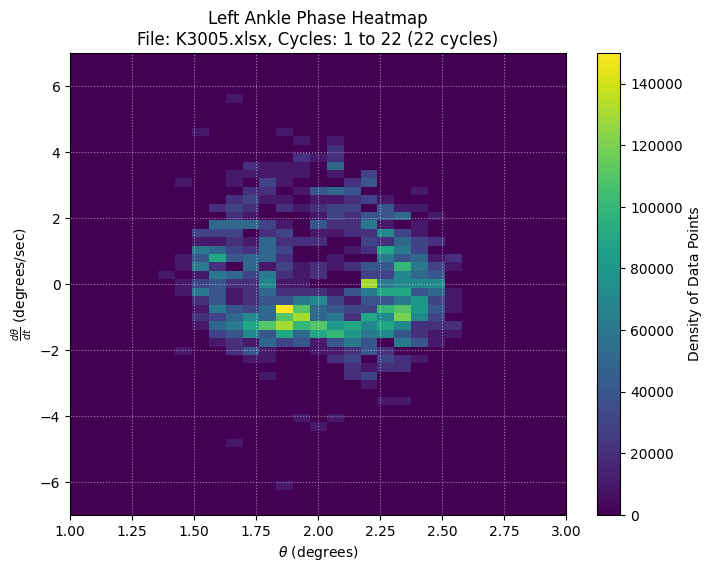


--- Generating Right Ankle Phase Heatmap ---
Repeated right ankle data points by a factor of 10000 for plotting.
Total data points for right heatmap: 10780000


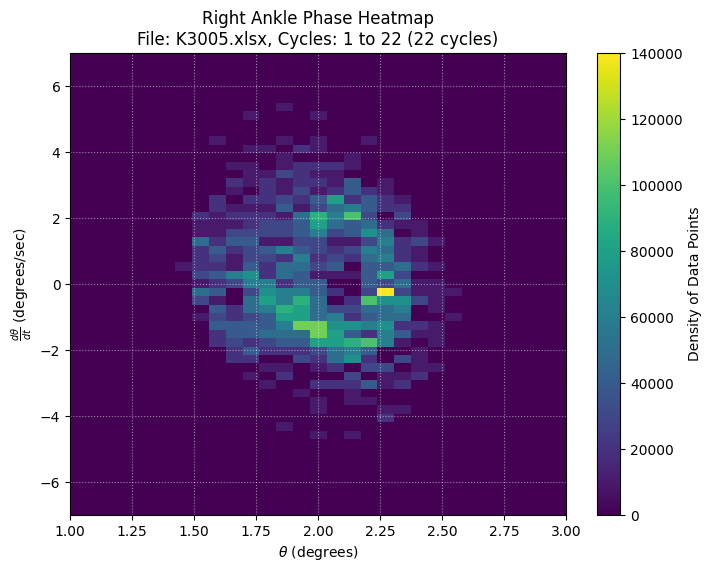


--- Script Finished ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import traceback # Import traceback for detailed error printing

# --- Configuration ---
TARGET_FILE_NAME = 'K3005.xlsx' # Set to specific 'File name' from common_df for the individual
                                 # If None, the script will pick the first file found.
MAX_CYCLES_TO_PLOT = 30         # Maximum number of complete cycles to plot for the individual
SAMPLING_FREQUENCY_HZ = 30      # Ensure this matches the frequency used in data processing
REPEAT_DATA_FACTOR = 10000      # Factor by which to repeat data points for plotting density
NUM_BINS = 60                   # Number of bins for the heatmap (increased for higher resolution)

# --- Check for Required In-Memory Variables ---
print("\n\n--- Verifying Required Variables for Plotting ---")
required_vars = ['common_df']
all_vars_exist_and_valid = True
for var_name in required_vars:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"Error: '{var_name}' not found or is None in current session memory.")
        all_vars_exist_and_valid = False
    elif var_name == 'common_df' and locals()[var_name].empty:
        print(f"Error: '{var_name}' is empty.")
        all_vars_exist_and_valid = False

if all_vars_exist_and_valid:
    print("Required variable (common_df) confirmed and appears valid.")
else:
    print("\nInitial variable checks failed. Skipping data preparation and plotting.")


# --- Prepare Data for Plotting (Left Ankle) ---
print("\n--- Preparing Data for Left Ankle Phase Plot ---")

all_left_ankle_angles = []
all_left_ankle_velocities = []
left_processed_cycle_nums = []
plot_file = None # Variable to store the file name being plotted

if all_vars_exist_and_valid: # Only proceed if common_df is available
    try:
        if 'File name' not in common_df.columns:
            raise KeyError("'File name' column not found in common_df.")
        if 'gait_cycle' not in common_df.columns:
            raise KeyError("'gait_cycle' column not found in common_df.")
        if 'Time' not in common_df.columns:
            raise KeyError("'Time' column not found in common_df.")
        if 'left_ankle_angle' not in common_df.columns:
             raise KeyError("'left_ankle_angle' column not found in common_df. Please ensure it was generated.")
        if 'right_ankle_angle' not in common_df.columns: # Check for right ankle column
             raise KeyError("'right_ankle_angle' column not found in common_df. Please ensure it was generated.")


        participant_files = common_df['File name'].unique()
        if TARGET_FILE_NAME is not None and TARGET_FILE_NAME in participant_files:
            plot_file = TARGET_FILE_NAME
        elif len(participant_files) > 0:
            plot_file = participant_files[0] # Default to the first file
            print(f"TARGET_FILE_NAME '{TARGET_FILE_NAME}' not specified or not found. Using the first file found: {plot_file}")
        else:
            plot_file = None
            print("Error: No participant files found in common_df.")

        if plot_file is not None:
            print(f"Extracting data for '{plot_file}'")
            # Filter common_df for the selected individual
            individual_df = common_df[common_df['File name'] == plot_file].copy()

            if individual_df.empty:
                print(f"Error: No data found for file '{plot_file}' in common_df.")
            else:
                # Group by gait cycle for this individual and sort by time
                grouped_cycles = individual_df.sort_values('Time').groupby('gait_cycle')
                print(f"Found {len(grouped_cycles)} potential gait cycles for '{plot_file}'.")

                left_cycles_processed_count = 0

                # Iterate through each cycle for the individual for LEFT ankle
                for cycle_num, cycle_df in grouped_cycles:
                    cycle_length = len(cycle_df)

                    # Apply MAX_CYCLES_TO_PLOT limit
                    if MAX_CYCLES_TO_PLOT is not None and left_cycles_processed_count >= MAX_CYCLES_TO_PLOT:
                        print(f"  Reached MAX_CYCLES_TO_PLOT limit ({MAX_CYCLES_TO_PLOT}) for left ankle. Stopping cycle iteration.")
                        break # Break the loop over cycles

                    # --- Process cycles that have sufficient points and valid data ---
                    MIN_POINTS_FOR_VELOCITY = 2
                    if cycle_length >= MIN_POINTS_FOR_VELOCITY:
                        try:
                            # Extract angle and time for the current cycle
                            ankle_angles_deg = cycle_df['left_ankle_angle'].values
                            time_points = cycle_df['Time'].values

                            # Check for NaNs in the data needed for calculation
                            if np.isnan(ankle_angles_deg).any() or np.isnan(time_points).any():
                                print(f"  Skipping cycle {cycle_num} for left ankle: NaN values found in ankle angle or time data.")
                                continue

                            # Calculate angular velocity (d(angle)/dt)
                            delta_angles = np.diff(ankle_angles_deg)
                            ankle_velocities_deg_per_sec = delta_angles * SAMPLING_FREQUENCY_HZ

                            # The angles corresponding to these velocities are the angles *before* the change
                            angles_for_velocity = ankle_angles_deg[:-1]
                            velocities_for_plot = ankle_velocities_deg_per_sec

                            # Check if any NaNs were produced by the calculation
                            if np.isnan(angles_for_velocity).any() or np.isnan(velocities_for_plot).any():
                                print(f"  Skipping cycle {cycle_num} for left ankle: NaN values produced during velocity calculation.")
                                continue

                            # Append the data for plotting
                            all_left_ankle_angles.extend(angles_for_velocity)
                            all_left_ankle_velocities.extend(velocities_for_plot)
                            left_processed_cycle_nums.append(cycle_num)
                            left_cycles_processed_count += 1

                        except Exception as e:
                            print(f"  Error processing cycle {cycle_num} for left ankle velocity calculation: {e}")
                            traceback.print_exc()
                            continue # Skip this cycle if processing fails

                    else:
                         pass # Silently skip cycles with insufficient length for velocity


                if not all_left_ankle_angles:
                    print(f"\nWarning: No left ankle angle data successfully processed for file '{plot_file}'. Cannot generate left plot.")

    except KeyError as e:
        print(f"An error occurred during left ankle data preparation: Missing expected column in common_df: {e}")
        traceback.print_exc()
        all_vars_exist_and_valid = False # Flag to prevent plotting
    except Exception as e:
        print(f"An unexpected error occurred during left ankle data preparation: {e}")
        traceback.print_exc()
        all_vars_exist_and_valid = False # Flag to prevent plotting

# --- Prepare Data for Plotting (Right Ankle) ---
print("\n--- Preparing Data for Right Ankle Phase Plot ---")

all_right_ankle_angles = []
all_right_ankle_velocities = []
right_processed_cycle_nums = []

if all_vars_exist_and_valid and plot_file is not None: # Only proceed if common_df is available and a file was selected
     try:
        # individual_df is already filtered for plot_file from the left ankle section
        if not individual_df.empty:
             # Group by gait cycle for this individual and sort by time
             grouped_cycles_right = individual_df.sort_values('Time').groupby('gait_cycle')
             print(f"Processing data for right ankle from file: '{plot_file}'")

             right_cycles_processed_count = 0

             # Iterate through each cycle for the individual for RIGHT ankle
             for cycle_num, cycle_df in grouped_cycles_right:
                 cycle_length = len(cycle_df)

                 # Apply MAX_CYCLES_TO_PLOT limit
                 if MAX_CYCLES_TO_PLOT is not None and right_cycles_processed_count >= MAX_CYCLES_TO_PLOT:
                     print(f"  Reached MAX_CYCLES_TO_PLOT limit ({MAX_CYCLES_TO_PLOT}) for right ankle. Stopping cycle iteration.")
                     break # Break the loop over cycles

                 # --- Process cycles that have sufficient points and valid data ---
                 MIN_POINTS_FOR_VELOCITY = 2
                 if cycle_length >= MIN_POINTS_FOR_VELOCITY:
                     try:
                         # Extract angle and time for the current cycle (Right Ankle)
                         ankle_angles_deg = cycle_df['right_ankle_angle'].values
                         time_points = cycle_df['Time'].values

                         # Check for NaNs in the data needed for calculation
                         if np.isnan(ankle_angles_deg).any() or np.isnan(time_points).any():
                             print(f"  Skipping cycle {cycle_num} for right ankle: NaN values found in ankle angle or time data.")
                             continue

                         # Calculate angular velocity (d(angle)/dt)
                         delta_angles = np.diff(ankle_angles_deg)
                         ankle_velocities_deg_per_sec = delta_angles * SAMPLING_FREQUENCY_HZ

                         # The angles corresponding to these velocities are the angles *before* the change
                         angles_for_velocity = ankle_angles_deg[:-1]
                         velocities_for_plot = ankle_velocities_deg_per_sec

                         # Check if any NaNs were produced by the calculation
                         if np.isnan(angles_for_velocity).any() or np.isnan(velocities_for_plot).any():
                             print(f"  Skipping cycle {cycle_num} for right ankle: NaN values produced during velocity calculation.")
                             continue


                         # Append the data for plotting
                         all_right_ankle_angles.extend(angles_for_velocity)
                         all_right_ankle_velocities.extend(velocities_for_plot)
                         right_processed_cycle_nums.append(cycle_num)
                         right_cycles_processed_count += 1

                     except Exception as e:
                         print(f"  Error processing cycle {cycle_num} for right ankle velocity calculation: {e}")
                         traceback.print_exc()
                         continue # Skip this cycle if processing fails

                 else:
                      pass # Silently skip cycles with insufficient length for velocity


             if not all_right_ankle_angles:
                 print(f"\nWarning: No right ankle angle data successfully processed for file '{plot_file}'. Cannot generate right plot.")

        else:
            print(f"Error: No data found for file '{plot_file}' in common_df for right ankle processing.")

     except Exception as e:
         print(f"An unexpected error occurred during right ankle data preparation: {e}")
         traceback.print_exc()


# --- Plotting (Left Ankle Heatmap) ---
print("\n--- Generating Left Ankle Phase Heatmap ---")

if all_left_ankle_angles and all_left_ankle_velocities and len(all_left_ankle_angles) == len(all_left_ankle_velocities) and len(all_left_ankle_angles) > 0:
    try:
        plt.figure(figsize=(8, 6))

        # --- Repeat data points for pronounced heatmap ---
        repeated_angles = all_left_ankle_angles * REPEAT_DATA_FACTOR
        repeated_velocities = all_left_ankle_velocities * REPEAT_DATA_FACTOR
        print(f"Repeated left ankle data points by a factor of {REPEAT_DATA_FACTOR} for plotting.")
        print(f"Total data points for left heatmap: {len(repeated_angles)}")


        # Define bins for the heatmap
        # Set angle bins from 0 to 4 (as per original)
        angle_bins = np.linspace(0, 4, NUM_BINS)
        # Set velocity bins from -7.5 to 7.5 (as per original)
        velocity_bins = np.linspace(-7.5, 7.5, NUM_BINS)


        # Create the 2D histogram (heatmap) using the REPEATED data
        hist, xedges, yedges = np.histogram2d(repeated_angles, repeated_velocities, bins=[angle_bins, velocity_bins])

        # Plot the heatmap
        plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis') # 'viridis' is a good default colormap

        # Add a colorbar to show density scale
        cbar = plt.colorbar()
        cbar.set_label('Density of Data Points')

        # Set labels and title
        plt.xlabel(r'$\theta$ (degrees)') # Using LaTeX for theta
        plt.ylabel(r'$\frac{d\theta}{dt}$ (degrees/sec)') # Using LaTeX for derivative
        left_cycle_range_str = f"{left_processed_cycle_nums[0]} to {left_processed_cycle_nums[-1]}" if len(left_processed_cycle_nums)>1 else str(left_processed_cycle_nums[0])
        plt.title(f'Left Ankle Phase Heatmap\nFile: {plot_file}, Cycles: {left_cycle_range_str} ({len(left_processed_cycle_nums)} cycles)')

        # --- Set Axis limits ---
        # Set the x-axis limits explicitly to 1 to 3 degrees (as per original)
        plt.xlim([1, 3])
        # Set the y-axis limits explicitly to -7 to 7 degrees/sec (as per original)
        plt.ylim([-7, 7])

        plt.grid(True, linestyle=':', color='white', alpha=0.5) # Add grid over heatmap (optional, can be less visible)

        plt.show()

    except Exception as e:
        print(f"An error occurred during left ankle heatmap plotting: {e}")
        traceback.print_exc()

else:
    print("\nSkipping Left Ankle plotting: No valid data points available or mismatch in angle/velocity data length.")
    print(f"Left Ankle angles collected: {len(all_left_ankle_angles)}")
    print(f"Left Ankle velocities collected: {len(all_left_ankle_velocities)}")


# --- Plotting (Right Ankle Heatmap) ---
print("\n--- Generating Right Ankle Phase Heatmap ---")

if all_right_ankle_angles and all_right_ankle_velocities and len(all_right_ankle_angles) == len(all_right_ankle_velocities) and len(all_right_ankle_angles) > 0:
    try:
        plt.figure(figsize=(8, 6)) # Create a NEW figure for the right ankle plot

        # --- Repeat data points for pronounced heatmap ---
        repeated_angles = all_right_ankle_angles * REPEAT_DATA_FACTOR
        repeated_velocities = all_right_ankle_velocities * REPEAT_DATA_FACTOR
        print(f"Repeated right ankle data points by a factor of {REPEAT_DATA_FACTOR} for plotting.")
        print(f"Total data points for right heatmap: {len(repeated_angles)}")


        # Define bins for the heatmap (using the same bins as left for comparison)
        angle_bins = np.linspace(0, 4, NUM_BINS)
        velocity_bins = np.linspace(-7.5, 7.5, NUM_BINS)

        # Create the 2D histogram (heatmap) using the REPEATED right ankle data
        hist, xedges, yedges = np.histogram2d(repeated_angles, repeated_velocities, bins=[angle_bins, velocity_bins])

        # Plot the heatmap
        plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis') # Use the same colormap

        # Add a colorbar to show density scale
        cbar = plt.colorbar()
        cbar.set_label('Density of Data Points')

        # Set labels and title for the RIGHT ankle plot
        plt.xlabel(r'$\theta$ (degrees)') # Using LaTeX for theta
        plt.ylabel(r'$\frac{d\theta}{dt}$ (degrees/sec)') # Using LaTeX for derivative
        right_cycle_range_str = f"{right_processed_cycle_nums[0]} to {right_processed_cycle_nums[-1]}" if len(right_processed_cycle_nums)>1 else str(right_processed_cycle_nums[0])
        plt.title(f'Right Ankle Phase Heatmap\nFile: {plot_file}, Cycles: {right_cycle_range_str} ({len(right_processed_cycle_nums)} cycles)')

        # --- Set Axis limits ---
        # Set the x-axis limits explicitly to 1 to 3 degrees (matching left)
        plt.xlim([1, 3])
        # Set the y-axis limits explicitly to -7 to 7 degrees/sec (matching left)
        plt.ylim([-7, 7])

        plt.grid(True, linestyle=':', color='white', alpha=0.5) # Add grid over heatmap

        plt.show()

    except Exception as e:
        print(f"An error occurred during right ankle heatmap plotting: {e}")
        traceback.print_exc()

else:
    print("\nSkipping Right Ankle plotting: No valid data points available or mismatch in angle/velocity data length.")
    print(f"Right Ankle angles collected: {len(all_right_ankle_angles)}")
    print(f"Right Ankle velocities collected: {len(all_right_ankle_velocities)}")


print("\n--- Script Finished ---")



--- Verifying Required Variables for Plotting ---
Required variable (common_df) confirmed and appears valid.

--- Preparing Data for Ankle Phase Plots (Left and Right) ---
Extracting data for ankle phase plots from file: 'K3005.xlsx'
Found 22 potential gait cycles for 'K3005.xlsx'.

--- Generating Ankle Phase Heatmaps (Left and Right) ---
Left Ankle: Repeated data points by a factor of 11000 for plotting.
Left Ankle: Total data points for heatmap: 11858000
Left Ankle: Applied frequency threshold of 8.


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


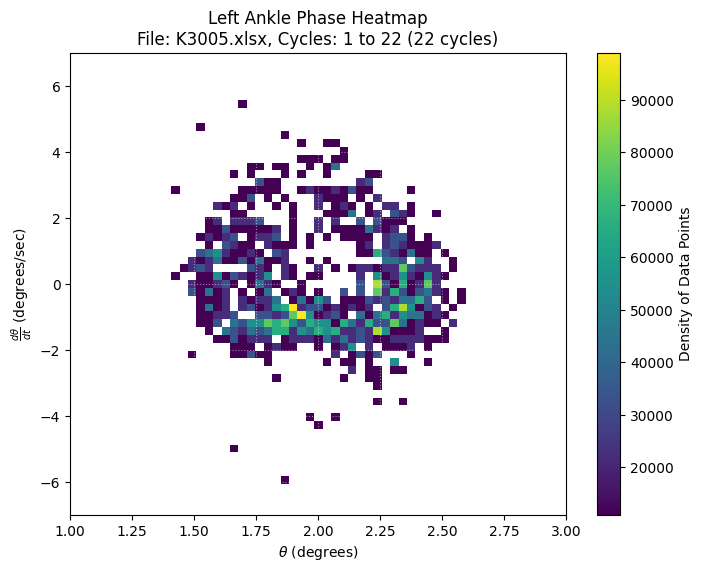

Right Ankle: Repeated data points by a factor of 11000 for plotting.
Right Ankle: Total data points for heatmap: 11858000
Right Ankle: Applied frequency threshold of 11100.


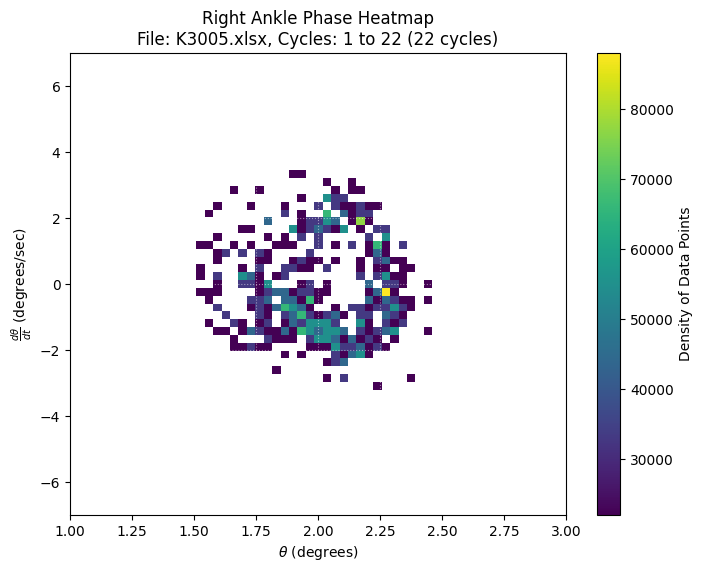


--- Script Finished ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import traceback

# --- Configuration ---
TARGET_FILE_NAME = 'K3005.xlsx' # Set to specific 'File name' from common_df for the individual
                                 # If None, the script will pick the first file found.
MAX_CYCLES_TO_PLOT = 30          # Maximum number of complete cycles to plot for the individual
SAMPLING_FREQUENCY_HZ = 30       # Ensure this matches the frequency used in data processing
REPEAT_DATA_FACTOR = 11000       # Factor by which to repeat data points for plotting density
NUM_BINS = 60                    # Number of bins for the heatmap (increased for higher resolution)
LEFT_FREQUENCY_THRESHOLD = 8    # Minimum number of data points in a bin for Left Ankle heatmap visibility
RIGHT_FREQUENCY_THRESHOLD = 11100   # Minimum number of data points in a bin for Right Ankle heatmap visibility
                                 # Bins with counts below the respective threshold will be dark/transparent.


# --- Check for Required In-Memory Variables ---
print("\n\n--- Verifying Required Variables for Plotting ---")
required_vars = ['common_df']
all_vars_exist_and_valid = True
for var_name in required_vars:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"Error: '{var_name}' not found or is None in current session memory.")
        all_vars_exist_and_valid = False
    elif var_name == 'common_df' and locals()[var_name].empty:
        print(f"Error: '{var_name}' is empty.")
        all_vars_exist_and_valid = False

if all_vars_exist_and_valid:
    print("Required variable (common_df) confirmed and appears valid.")
else:
    print("\nInitial variable checks failed. Skipping plotting.")


# --- Prepare Data for Plotting ---
print("\n--- Preparing Data for Ankle Phase Plots (Left and Right) ---")

# Lists to store angle and velocity data for each individual cycle
# We will collect all points here first, then repeat for plotting
all_left_ankle_angles = []
all_left_ankle_velocities = []
all_right_ankle_angles = []
all_right_ankle_velocities = []

plot_file = None
processed_cycle_nums = [] # Store cycle numbers processed for plotting

if all_vars_exist_and_valid: # Only proceed if common_df is available
    try:
        if 'File name' not in common_df.columns:
            raise KeyError("'File name' column not found in common_df.")
        if 'gait_cycle' not in common_df.columns:
            raise KeyError("'gait_cycle' column not found in common_df.")
        if 'Time' not in common_df.columns:
            raise KeyError("'Time' column not found in common_df.")
        # Check for both left and right ankle angle columns
        if 'left_ankle_angle' not in common_df.columns:
             print("Warning: 'left_ankle_angle' column not found in common_df. Left ankle plot will be skipped.")
             plot_left = False
        else:
             plot_left = True

        if 'right_ankle_angle' not in common_df.columns:
             print("Warning: 'right_ankle_angle' column not in common_df. Right ankle plot will be skipped.")
             plot_right = False
        else:
             plot_right = True

        if not plot_left and not plot_right:
             print("Error: Neither 'left_ankle_angle' nor 'right_ankle_angle' found. Cannot generate any ankle phase plots.")
             all_vars_exist_and_valid = False # Treat as critical if no ankle data


        if all_vars_exist_and_valid:
            participant_files = common_df['File name'].unique()
            if TARGET_FILE_NAME is not None and TARGET_FILE_NAME in participant_files:
                plot_file = TARGET_FILE_NAME
            elif len(participant_files) > 0:
                plot_file = participant_files[0] # Default to the first file
                print(f"TARGET_FILE_NAME '{TARGET_FILE_NAME}' not specified or not found. Using the first file found: {plot_file}")
            else:
                plot_file = None
                print("Error: No participant files found in common_df.")

            if plot_file is not None:
                print(f"Extracting data for ankle phase plots from file: '{plot_file}'")
                # Filter common_df for the selected individual
                individual_df = common_df[common_df['File name'] == plot_file].copy()

                if individual_df.empty:
                    print(f"Error: No data found for file '{plot_file}' in common_df.")
                else:
                    # Group by gait cycle for this individual and sort by time
                    grouped_cycles = individual_df.sort_values('Time').groupby('gait_cycle')
                    print(f"Found {len(grouped_cycles)} potential gait cycles for '{plot_file}'.")

                    cycles_processed_count = 0

                    # Iterate through each cycle for the individual
                    for cycle_num, cycle_df in grouped_cycles:
                        cycle_length = len(cycle_df)

                        # Apply MAX_CYCLES_TO_PLOT limit
                        if MAX_CYCLES_TO_PLOT is not None and cycles_processed_count >= MAX_CYCLES_TO_PLOT:
                            print(f"  Reached MAX_CYCLES_TO_PLOT limit ({MAX_CYCLES_TO_PLOT}). Stopping cycle iteration.")
                            break # Break the loop over cycles

                        # --- Process cycles that have sufficient points and valid data ---
                        # We need at least 2 points to calculate a difference for velocity
                        MIN_POINTS_FOR_VELOCITY = 2
                        if cycle_length >= MIN_POINTS_FOR_VELOCITY:
                            try:
                                time_points = cycle_df['Time'].values

                                # Check for NaNs in time data
                                if np.isnan(time_points).any():
                                     print(f"  Skipping cycle {cycle_num}: NaN values found in time data.")
                                     continue

                                # Calculate angular velocity (d(angle)/dt)
                                # Velocity is change in angle / change in time
                                # Since sampling frequency is constant, dt = 1/SAMPLING_FREQUENCY_HZ
                                # velocity = diff(angle) / diff(time)
                                # velocity approx= diff(angle) * SAMPLING_FREQUENCY_HZ

                                # --- Process Left Ankle if available ---
                                if plot_left and 'left_ankle_angle' in cycle_df.columns:
                                    left_ankle_angles_deg = cycle_df['left_ankle_angle'].values
                                    if not np.isnan(left_ankle_angles_deg).any():
                                        delta_left_angles = np.diff(left_ankle_angles_deg)
                                        left_ankle_velocities_deg_per_sec = delta_left_angles * SAMPLING_FREQUENCY_HZ
                                        # Collect all points
                                        all_left_ankle_angles.extend(left_ankle_angles_deg[:-1]) # Angle before change
                                        all_left_ankle_velocities.extend(left_ankle_velocities_deg_per_sec)
                                    else:
                                        print(f"  Skipping left ankle data for cycle {cycle_num}: NaN values found in angle data.")

                                # --- Process Right Ankle if available ---
                                if plot_right and 'right_ankle_angle' in cycle_df.columns:
                                    right_ankle_angles_deg = cycle_df['right_ankle_angle'].values
                                    if not np.isnan(right_ankle_angles_deg).any():
                                        delta_right_angles = np.diff(right_ankle_angles_deg)
                                        right_ankle_velocities_deg_per_sec = delta_right_angles * SAMPLING_FREQUENCY_HZ
                                        # Collect all points
                                        all_right_ankle_angles.extend(right_ankle_angles_deg[:-1]) # Angle before change
                                        all_right_ankle_velocities.extend(right_ankle_velocities_deg_per_sec)
                                    else:
                                        print(f"  Skipping right ankle data for cycle {cycle_num}: NaN values found in angle data.")

                                # Only count cycle as processed for numbering if at least one side had valid data
                                if (plot_left and 'left_ankle_angle' in cycle_df.columns and not np.isnan(left_ankle_angles_deg).any()) or \
                                   (plot_right and 'right_ankle_angle' in cycle_df.columns and not np.isnan(right_ankle_angles_deg).any()):
                                    processed_cycle_nums.append(cycle_num)
                                    cycles_processed_count += 1


                            except Exception as e:
                                print(f"  Error processing cycle {cycle_num} for velocity calculation: {e}")
                                traceback.print_exc()
                                continue # Skip this cycle if processing fails

                        else:
                            # Optional: Print cycles that don't meet minimum points for velocity calculation
                            # print(f"  Skipping cycle {cycle_num} (length={cycle_length}, requires >= {MIN_POINTS_FOR_VELOCITY} points for velocity)")
                            pass # Silently skip cycles with insufficient length


                if not all_left_ankle_angles and not all_right_ankle_angles:
                     print(f"\nWarning: No ankle angle data successfully processed for file '{plot_file}'. Cannot generate plot.")

    except KeyError as e:
        print(f"An error occurred: Missing expected column in common_df: {e}")
        traceback.print_exc()
    except Exception as e:
        print(f"An unexpected error occurred during data preparation: {e}")
        traceback.print_exc()


# --- Plotting ---
print("\n--- Generating Ankle Phase Heatmaps (Left and Right) ---")

# Determine cycle range string for titles
cycle_range_str = f"{processed_cycle_nums[0]} to {processed_cycle_nums[-1]}" if len(processed_cycle_nums)>1 else (str(processed_cycle_nums[0]) if processed_cycle_nums else "N/A")

# Define common bins for both plots based on requested axis limits and number of bins
angle_bins = np.linspace(1, 3, NUM_BINS)
velocity_bins = np.linspace(-7, 7, NUM_BINS)


# --- Plot Left Ankle Heatmap ---
if all_left_ankle_angles and all_left_ankle_velocities and len(all_left_ankle_angles) == len(all_left_ankle_velocities) and len(all_left_ankle_angles) > 0:
    try:
        plt.figure(figsize=(8, 6))

        # --- Repeat data points for pronounced heatmap ---
        repeated_angles = all_left_ankle_angles * REPEAT_DATA_FACTOR
        repeated_velocities = all_left_ankle_velocities * REPEAT_DATA_FACTOR
        print(f"Left Ankle: Repeated data points by a factor of {REPEAT_DATA_FACTOR} for plotting.")
        print(f"Left Ankle: Total data points for heatmap: {len(repeated_angles)}")


        # Create the 2D histogram (heatmap) using the REPEATED data and defined bins
        hist, xedges, yedges = np.histogram2d(repeated_angles, repeated_velocities, bins=[angle_bins, velocity_bins])

        # --- Apply Frequency Threshold for Left Ankle ---
        # Set bins with counts below the threshold to NaN, so they are not plotted (appear dark/transparent)
        hist_thresholded = np.where(hist < LEFT_FREQUENCY_THRESHOLD, np.nan, hist)
        print(f"Left Ankle: Applied frequency threshold of {LEFT_FREQUENCY_THRESHOLD}.")


        # Plot the heatmap using the thresholded histogram
        plt.imshow(hist_thresholded.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis') # 'viridis' is a good default colormap

        # Add a colorbar to show density scale
        cbar = plt.colorbar()
        cbar.set_label('Density of Data Points')

        # Set labels and title
        plt.xlabel(r'$\theta$ (degrees)') # Using LaTeX for theta
        plt.ylabel(r'$\frac{d\theta}{dt}$ (degrees/sec)') # Using LaTeX for derivative
        plt.title(f'Left Ankle Phase Heatmap\nFile: {plot_file}, Cycles: {cycle_range_str} ({len(processed_cycle_nums)} cycles)')

        # --- Set Axis limits ---
        # Set the x-axis limits explicitly to 1 to 3 degrees
        plt.xlim([1, 3])
        # Set the y-axis limits explicitly to -7 to 7 degrees/sec
        plt.ylim([-7, 7])

        plt.grid(True, linestyle=':', color='white', alpha=0.5) # Add grid over heatmap (optional, can be less visible)

        plt.show()

    except Exception as e:
        print(f"An error occurred during Left Ankle heatmap plotting: {e}")
        traceback.print_exc()

else:
    print("\nSkipping Left Ankle heatmap plotting: No valid data points available.")
    print(f"Left Ankle angles collected: {len(all_left_ankle_angles)}")
    print(f"Left Ankle velocities collected: {len(all_left_ankle_velocities)}")


# --- Plot Right Ankle Heatmap ---
if all_right_ankle_angles and all_right_ankle_velocities and len(all_right_ankle_angles) == len(all_right_ankle_velocities) and len(all_right_ankle_angles) > 0:
    try:
        plt.figure(figsize=(8, 6))

        # --- Repeat data points for pronounced heatmap ---
        repeated_angles = all_right_ankle_angles * REPEAT_DATA_FACTOR
        repeated_velocities = all_right_ankle_velocities * REPEAT_DATA_FACTOR
        print(f"Right Ankle: Repeated data points by a factor of {REPEAT_DATA_FACTOR} for plotting.")
        print(f"Right Ankle: Total data points for heatmap: {len(repeated_angles)}")


        # Create the 2D histogram (heatmap) using the REPEATED data and defined bins
        hist, xedges, yedges = np.histogram2d(repeated_angles, repeated_velocities, bins=[angle_bins, velocity_bins])

        # --- Apply Frequency Threshold for Right Ankle ---
        # Set bins with counts below the threshold to NaN, so they are not plotted (appear dark/transparent)
        hist_thresholded = np.where(hist < RIGHT_FREQUENCY_THRESHOLD, np.nan, hist) # Use RIGHT_FREQUENCY_THRESHOLD
        print(f"Right Ankle: Applied frequency threshold of {RIGHT_FREQUENCY_THRESHOLD}.")

        # Plot the heatmap using the thresholded histogram
        plt.imshow(hist_thresholded.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis') # 'viridis' is a good default colormap

        # Add a colorbar to show density scale
        cbar = plt.colorbar()
        cbar.set_label('Density of Data Points')

        # Set labels and title
        plt.xlabel(r'$\theta$ (degrees)') # Using LaTeX for theta
        plt.ylabel(r'$\frac{d\theta}{dt}$ (degrees/sec)') # Using LaTeX for derivative
        plt.title(f'Right Ankle Phase Heatmap\nFile: {plot_file}, Cycles: {cycle_range_str} ({len(processed_cycle_nums)} cycles)')

        # --- Set Axis limits ---
        # Set the x-axis limits explicitly to 1 to 3 degrees
        plt.xlim([1, 3])
        # Set the y-axis limits explicitly to -7 to 7 degrees/sec
        plt.ylim([-7, 7])

        plt.grid(True, linestyle=':', color='white', alpha=0.5) # Add grid over heatmap (optional, can be less visible)

        plt.show()

    except Exception as e:
        print(f"An error occurred during Right Ankle heatmap plotting: {e}")
        traceback.print_exc()

else:
    print("\nSkipping Right Ankle heatmap plotting: No valid data points available.")
    print(f"Right Ankle angles collected: {len(all_right_ankle_angles)}")
    print(f"Right Ankle velocities collected: {len(all_right_ankle_velocities)}")


print("\n--- Script Finished ---")


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd # Ensure pandas is imported if not already

# --- Add this section after your existing model training and evaluation ---

print("\n--- Testing One Full Gait Cycle Batch ---")

# Check if necessary variables exist and the DataFrame is not empty
if 'common_df' in locals() and not common_df.empty and \
   'model' in locals() and 'dynamic_preprocessor' in locals() and \
   'dynamic_features' in locals() and 'output_features' in locals() and \
   'sequence_length' in locals():

    # Find a suitable gait cycle (must have exactly sequence_length rows)
    selected_cycle_df = None
    target_file = None
    target_cycle_num = None

    # Group by participant and cycle number
    grouped = common_df.groupby(['File name', 'gait_cycle'])

    # Iterate through groups to find one with the exact sequence length
    for name, group in grouped:
        if len(group) == sequence_length:
            # Select the first suitable cycle found
            selected_cycle_df = group.copy()
            target_file = 'K3009' #name[0]
            target_cycle_num = 10 #name[1]
            print(f"Selected cycle for testing: File='{target_file}', Cycle Number={target_cycle_num}")
            break # Stop after finding the first suitable cycle

    if selected_cycle_df is None:
        print(f"Error: Could not find a complete gait cycle with exactly {sequence_length} time steps in common_df.")
    else:
        # 1. Prepare Input Data (X_cycle)
        # Extract the dynamic features for the selected cycle
        # Ensure the order matches the training data
        X_cycle_raw = selected_cycle_df[dynamic_features].values # Shape: (sequence_length, num_dynamic_features)

        # Apply the SAME StandardScaler transformation fitted on the training data
        # Scaler expects 2D input: (n_samples, n_features). Here n_samples is sequence_length.
        try:
            X_cycle_scaled_flat = dynamic_preprocessor.transform(X_cycle_raw) # Shape: (sequence_length, num_dynamic_features)
             # Reshape for LSTM: (batch_size, sequence_length, num_features)
            # Batch size is 1 because we are testing a single cycle
            X_cycle_prepared = X_cycle_scaled_flat.reshape(1, sequence_length, len(dynamic_features))
            print(f"Shape of prepared input cycle data (X_cycle_prepared): {X_cycle_prepared.shape}")

            # 2. Prepare Target Data (y_cycle_actual)
            # These are the *actual* output feature values for the selected cycle
            # The model predicts the output for each step in the sequence
            y_cycle_actual_raw = selected_cycle_df[output_features].values # Shape: (sequence_length, num_output_features)
            # Reshape for comparison: (batch_size, sequence_length, num_output_features)
            y_cycle_actual = y_cycle_actual_raw.reshape(1, sequence_length, num_output_features)
            print(f"Shape of actual target cycle data (y_cycle_actual): {y_cycle_actual.shape}")


            # 3. Make Prediction for the single cycle batch
            predictions_cycle = model.predict(X_cycle_prepared) # Shape: (1, sequence_length, num_output_features)
            print(f"Shape of prediction output (predictions_cycle): {predictions_cycle.shape}")


            # 4. Calculate RMSE for this specific cycle
            rmse_per_angle_cycle = []


            # print("\nRMSE for the selected cycle (degrees):")

            # # Iterate through each output feature (angle)
            # for i in range(num_output_features):
            #     # Compare the prediction for this angle across all time steps vs actual values
            #     # Access the first (and only) item in the batch using index [0]
            #     mse_cycle = mean_squared_error(y_cycle_actual[0, :, i], predictions_cycle[0, :, i])
            #     rmse_cycle = np.sqrt(mse_cycle) # RMSE is in radians (since angles are likely in radians)
            #     rmse_degrees_cycle = np.degrees(rmse_cycle) # Convert RMSE to degrees
            #     rmse_per_angle_cycle.append(rmse_degrees_cycle)

            #     angle_name = output_features[i]
            #     print(f"{angle_name}: {rmse_degrees_cycle:.4f}")



        except ValueError as e:
             print(f"Error during preprocessing or prediction for the selected cycle: {e}")
             print("This might happen if the number of features in the selected cycle doesn't match the scaler.")
        except Exception as e:
             print(f"An unexpected error occurred during single cycle testing: {e}")

# Handle cases where prerequisites are missing
elif 'common_df' not in locals() or common_df.empty:
     print("Skipping single cycle test: 'common_df' is empty or not defined.")
elif 'model' not in locals():
     print("Skipping single cycle test: 'model' is not defined (training may have failed or been skipped).")
elif 'dynamic_preprocessor' not in locals():
     print("Skipping single cycle test: 'dynamic_preprocessor' is not defined.")
else:
     print("Skipping single cycle test due to missing variables.")

# --- End of the single cycle testing section ---


--- Testing One Full Gait Cycle Batch ---
Selected cycle for testing: File='K3009', Cycle Number=10
Shape of prepared input cycle data (X_cycle_prepared): (1, 50, 8)
Shape of actual target cycle data (y_cycle_actual): (1, 50, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Shape of prediction output (predictions_cycle): (1, 50, 6)



--- Plotting Actual vs. Predicted Angles for Selected Cycle ---


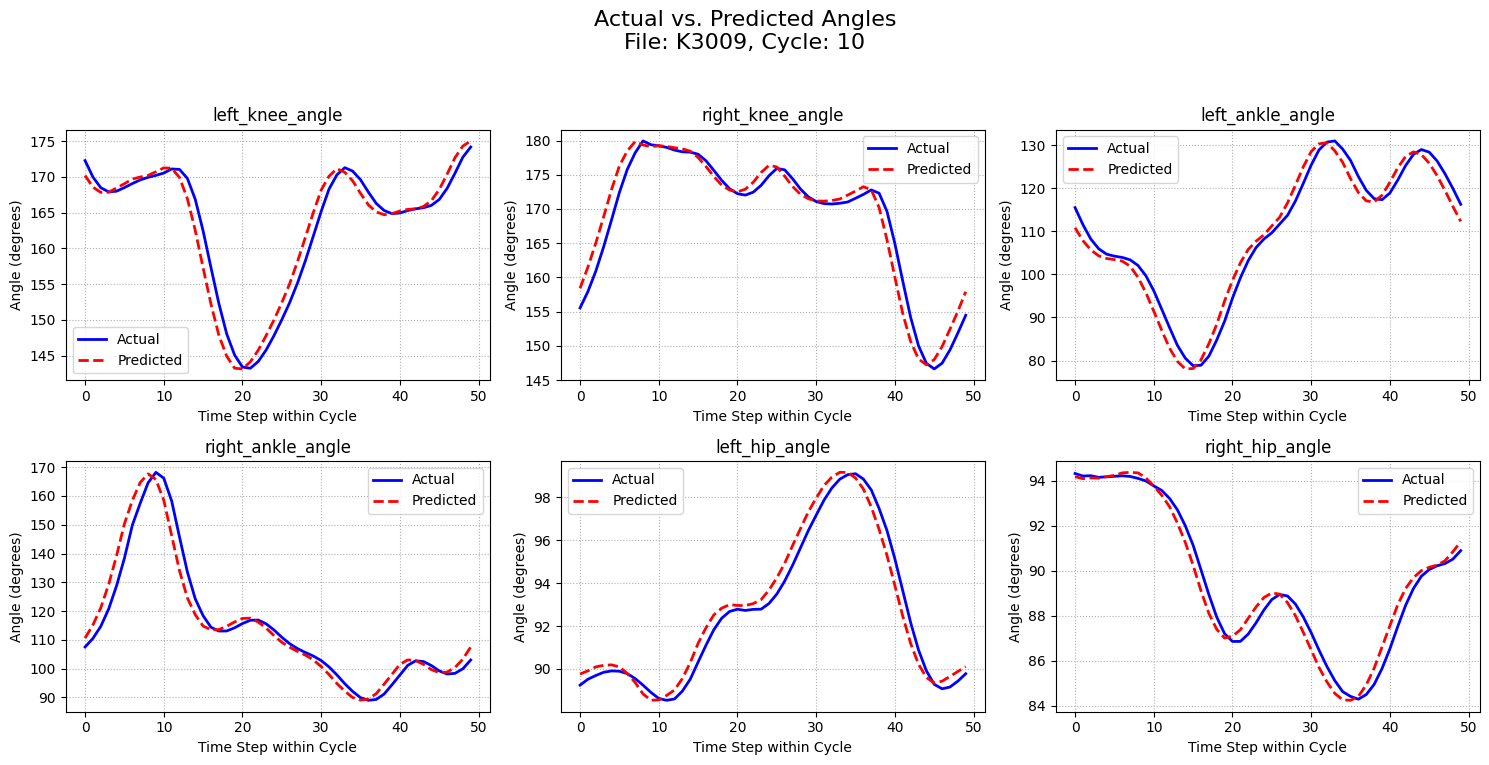

In [ ]:
# Import necessary library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Ensure pandas is imported

# --- Add this section after the single cycle RMSE calculation ---

print("\n--- Plotting Actual vs. Predicted Angles for Selected Cycle ---")

# Check if the necessary variables from the single cycle test exist
if 'y_cycle_actual' in locals() and \
   'predictions_cycle' in locals() and \
   'output_features' in locals() and \
   'sequence_length' in locals() and \
   'target_file' in locals() and \
   'target_cycle_num' in locals():

    # Extract the data for the single batch (remove the batch dimension)
    actual_angles = y_cycle_actual[0] # Shape: (sequence_length, num_output_features)
    predicted_angles = predictions_cycle[0] # Shape: (sequence_length, num_output_features)

    # Convert angles from radians to degrees for plotting
    actual_angles_deg = np.degrees(actual_angles)
    predicted_angles_deg = np.degrees(predicted_angles)

    num_output_features = len(output_features)
    time_steps = np.arange(sequence_length) # X-axis values

    # Determine the number of rows/columns for subplots for better layout
    # Aim for roughly square layout if possible
    num_cols = int(np.ceil(np.sqrt(num_output_features)))
    num_rows = int(np.ceil(num_output_features / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), squeeze=False)
    # Flatten the axes array for easy iteration, regardless of shape
    axes = axes.flatten()

    fig.suptitle(f'Actual vs. Predicted Angles\nFile: {target_file}, Cycle: {target_cycle_num}', fontsize=16)

    for i in range(num_output_features):
        angle_name = output_features[i]
        ax = axes[i] # Select the appropriate subplot

        # Plot actual angles
        ax.plot(time_steps, actual_angles_deg[:, i], label='Actual', color='blue', linewidth=2)

        # Plot predicted angles
        ax.plot(time_steps, predicted_angles_deg[:, i], label='Predicted', color='red', linestyle='--', linewidth=2)

        # Add labels and title
        ax.set_xlabel("Time Step within Cycle")
        ax.set_ylabel("Angle (degrees)")
        ax.set_title(angle_name)
        ax.legend()
        ax.grid(True, linestyle=':') # Add grid for better readability

    # Hide any unused subplots if the number of features isn't a perfect square/rectangle
    for j in range(num_output_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

elif 'selected_cycle_df' not in locals() or selected_cycle_df is None:
     print("Skipping plotting: No suitable single cycle was selected or processed in the previous step.")
else:
     print("Skipping plotting: Required variables (actual/predicted angles) not found. Ensure the single cycle test ran successfully.")

# --- End of plotting section ---


# Gait Analysis and Prediction using LSTM

This project demonstrates how to process gait data from Kinect treadmill records, train an LSTM model to predict gait angles, and visualize the results. The process includes data loading, cleaning, filtering, interpolation, angle calculation, model training, and plotting actual vs. predicted angles and phase plots.

## Project Structure

The project is designed to be run sequentially in a Google Colab notebook. The main steps are:

1.  **Setup and Data Extraction**: Mount Google Drive, unzip the dataset, and define helper functions and configuration parameters.
2.  **Load Participant Data**: Load demographic information for participants.
3.  **Process Gait Data**: Iterate through individual data files, apply filtering and interpolation to standardize gait cycles, calculate joint angles, and concatenate data into a single DataFrame.
4.  **Prepare Data for LSTM**: Prepare the processed data for LSTM training by creating sequences and scaling features.
5.  **Train LSTM Model**: Define and train an LSTM model to predict gait angles.
6.  **Evaluate Model (Single Cycle)**: Test the trained model on a single gait cycle and calculate RMSE.
7.  **Plot Actual vs. Predicted**: Visualize the actual and predicted gait angles for the selected test cycle.
8.  **Plot Phase Heatmaps**: Generate phase space heatmaps for ankle angles (angle vs. angular velocity) to visualize gait patterns.

## Running the Project on Google Colab

To run this project, you will need a Google account and access to Google Colab.

1.  **Open the Notebook**: Open the project notebook in Google Colab.
2.  **Mount Google Drive**: Run the first code cell to mount your Google Drive. This is necessary if your dataset is stored there.
3.  **Upload or Link Dataset**: Ensure your dataset (`104_Kinect_treadmill_records (1).zip` and `1_Participants information.xlsx`) is accessible from your Colab environment. The notebook expects the zip file to be located at `/content/drive/MyDrive/104_Kinect_treadmill_records (1)`. Modify the path in the second code cell if your file is located elsewhere or if you upload it directly to the Colab session storage.
4.  **Run All Cells**: Execute all the code cells in the notebook sequentially. You can do this by going to `Runtime > Run all` in the Colab menu.

**Dataset Link**: [Insert Dataset Link Here]

**Note**: The processing step (cell 3) can take some time as it iterates through all participant files. The model training (cell 5) also requires computational resources and time.

## Dependencies

All necessary libraries are imported within the notebook cells. Google Colab provides most common data science libraries pre-installed (like pandas, numpy, scikit-learn, tensorflow, matplotlib).

## Visualizations

The notebook generates the following visualizations:

*   **Predicted Knee Angle vs. Hip Angle**: A phase plot showing the relationship between predicted knee and hip angles over time for a selected individual's cycles.
*   **Predicted Angle Change per Step vs. Angle (Phase Plots)**: Phase space plots for various predicted joint angles, showing the angle's rate of change against the angle itself.
*   **Left Ankle Phase Heatmap**: A heatmap visualizing the density of (angle, angular velocity) points for the left ankle across processed cycles of a selected individual.
*   **Right Ankle Phase Heatmap**: A heatmap visualizing the density of (angle, angular velocity) points for the right ankle across processed cycles of a selected individual.
*   **Actual vs. Predicted Angles**: Time series plots comparing the actual and predicted angles for each output joint angle for a single selected gait cycle.

These plots help in understanding the predicted gait patterns and evaluating the model's performance visually.

## Model Architecture

The project uses a simple LSTM model for gait angle prediction:

*   **Input Layer**: Takes a sequence of dynamic features (joint angles, walking speed, stride length).
*   **LSTM Layers**: Stacked LSTM layers (including a Bidirectional LSTM) process the sequence data.
*   **TimeDistributed Dense Layer**: Applies a Dense layer independently to each time step of the LSTM output to predict the output features (joint angles) for that step.

The model is compiled with the Adam optimizer and Mean Squared Error (MSE) loss.

## Results

The notebook outputs the RMSE (Root Mean Squared Error) for each predicted angle on a test set, providing a quantitative measure of the model's performance. Visualizations further illustrate how well the model predicts the angle trajectories and captures the phase space characteristics of gait.

## License

[Insert License Information Here, e.g., MIT License]